# Wallet Feature Engineering

The purpose of this notebook is to create features from OpenSea `Asset Events` time series
in order to:
- model and predict NFT fear of missing out (FOMO) behavior
- classify types of people participating in NFT exchanges

# Read Data

__Description of the dataset:__ Asset events ("events") were extracted by
 [莊惟翔](https://github.com/Fred-Zhuang)
via https://api.opensea.io/api/v1/assets endpoint.
This dateset contains only __successful__ events having occurred on the NFTs
and been tracked by OpenSea.

1. a list of `token_seller_address` having event timestamp
    between 2022-05-03 and 2022-05-18 was used as the primer to
    extract all events involving these addresses
    (see `os_successful_events.feather`)
1. only events involved one of the 21 selected NFT collections were considered
    for this study
1. the final list of events was then used for feature engineering
1. this list spans 406 days, between 2021-04-30 and 2022-06-11

*The `event_type` indicates the types of events (transfer, successful auction, etc)
and the results are sorted by `event_timestamp`
(see [OpenSea API documentation](https://docs.opensea.io/reference/getting-assets)).

In [1]:
import os
import time
import numpy as np
import numpy_financial as npf
import pandas as pd
import seaborn as sns

data_dir = os.path.join(os.getcwd(), 'data', 'wallets successful event')

start_time = time.time()
wallets = pd.read_parquet(os.path.join(data_dir, 'nft20_success.parquet'))
total_time = time.time() - start_time
print("Total seconds to load:", total_time)
wallets.info(show_counts=True)

Total seconds to load: 1.7212340831756592
<class 'pandas.core.frame.DataFrame'>
Int64Index: 600856 entries, 4436 to 14354
Data columns (total 36 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   index                             600856 non-null  int64         
 1   event_timestamp                   600856 non-null  datetime64[ns]
 2   event_type                        600856 non-null  object        
 3   token_id                          600284 non-null  object        
 4   num_sales                         600284 non-null  float64       
 5   listing_time                      554455 non-null  datetime64[ns]
 6   token_owner_address               600284 non-null  object        
 7   token_seller_address              600856 non-null  object        
 8   from_account_address              233 non-null     object        
 9   deal_price                        600856 non-null  float64 

In [2]:
wallets.drop(['index', 'starting_price', 'ending_price',
              'approved_account', 'bid_amount', 'custom_event_name',
              'filename'], axis=1, inplace=True)
print("Memory usage:", wallets.memory_usage().sum() / 1024**2, "MB")

Memory usage: 137.5250244140625 MB


In [3]:
print("Most recent event:", max(wallets.event_timestamp))

Most recent event: 2022-06-11 11:31:00


In [4]:
print("Earliest event:", min(wallets.event_timestamp))

Earliest event: 2021-04-30 12:38:59


In [5]:
print("Length of this time series dataset:", max(wallets.event_timestamp) - min(wallets.event_timestamp))

Length of this time series dataset: 406 days 22:52:01


In [6]:
print("Total number of wallet addresses used to retrieve data from OpenSea:", f'{wallets.wallet_address_input.nunique(): ,}')

Total number of wallet addresses used to retrieve data from OpenSea:  120,178


## NFT collections in this dataset

In [7]:
wallets.groupby(by='collection_slug') \
    .agg({'event_timestamp': 'size', 'wallet_address_input': 'nunique'}) \
    .sort_values(by='event_timestamp', ascending=False)

,event_timestamp,wallet_address_input
collection_slug,,
cool-cats-nft,51356,12197
lazy-lions,48777,12510
mutant-ape-yacht-club,48611,19147
boredapeyachtclub,46991,11311
world-of-women-nft,41479,10822
bored-ape-kennel-club,34723,10661
cryptoadz-by-gremplin,34225,9270
meebits,32332,9544
phantabear,31019,10341


\* _`event_timestamp` represents the number of successful sales, `wallet_address_input` the number of unique wallets._

## Data distribution (WIP)

... this project selects only transaction involving top-20 nft collections 

## Questions

- What is asset_event `created_date`, and how does it differ from `event_timestamp`?
  Would asset_contract created_date be more useful than asset_event created_date?
- Why are `starting_price` and `ending_price` always _null_?
- What can we do with `token_owner_address`?
- What can we do with `num_sales`? 
- `contract_address` appears to be the address of the smart contract used to execute the sales, i.e. exchange. How can we use this?

# Generate Features

## Impute data

### `buy` vs. `sell` event_type

_N.b._ The dataset is missing `winner_account_address` attribute to confirmed the buyer is indeed
the wallet owner, i.e. `wallet_address_input`. We therefore infer whether the wallet owner
is either the buyer or the seller as such:

In [8]:
wallets.event_type = np.where(wallets.wallet_address_input == wallets.token_seller_address, "sell", "buy")

In [9]:
wallets.groupby(by=['collection_slug', 'event_type']) \
    .agg({'event_timestamp': 'size', 'wallet_address_input': 'nunique'})

event_timestamp  wallet_address_input
collection_slug       event_type                                       
azuki                 buy                   15898                  7856
                      sell                  14325                  6474
bored-ape-kennel-club buy                   17540                  7998
                      sell                  17183                  7370
boredapeyachtclub     buy                   23358                  9133
                      sell                  23633                  7099
clonex                buy                   11534                  6673
                      sell                  10301                  4484
cool-cats-nft         buy                   25806                 10276
                      sell                  25550                  8048
coolpetsnft           buy                    8988                  4363
                      sell                  10679                  6580
cryptoadz-by-gremplin buy                   17359                  7984
                      sell                  16866                  6163
cyberkongz-vx         buy                   14556                  5637
                      sell                  13072                  4349
doodles-official      buy                   14709                  8352
                      sell                  12845                  5811
hapeprime             buy                    8947                  4984
                      sell                   9062                  6250
invisiblefriends      buy                    1960                  1405
                      sell                   2910                  2487
kaiju-kingz           buy                    6744                  4370
                      sell                   7215                  4159
karafuru              buy                    6709                  4256
                      sell                   6445                  4048
lazy-lions            buy                   24873                 10760
                      sell                  23904                  8322
meebits               buy                   16410                  6997
                      sell                  15922                  5627
mekaverse             buy                   11233                  5698
                      sell                  11667                  6711
mfers                 buy                   11977                  6657
                      sell                  10653                  4011
mutant-ape-yacht-club buy                   23927                 14056
                      sell                  24684                 12351
phantabear            buy                   15739                  7765
                      sell                  15280                  7200
proof-moonbirds       buy                    4601                  2610
                      sell                   4313                  3309
world-of-women-nft    buy                   21182                  8867
                      sell                  20297                  6932

### `duration`
the time between the token listed and the completion of the the sale

_What to do when listing_time is `NaT`_? << We will fill duration NA with `pd.Timedelta(0)`, i.e. 0

In [10]:
wallets.query('duration.isna()').loc[:,["event_timestamp", "event_type", "listing_time", "payment_token_symbol", "deal_price"]].sort_values('listing_time')

,event_timestamp,event_type,listing_time,payment_token_symbol,deal_price
492057,2021-05-01 02:17:39,buy,2021-04-30 22:49:25,ETH,1.000000e+17
265062,2021-05-01 02:17:39,sell,2021-04-30 22:49:25,ETH,1.000000e+17
117124,2021-05-01 08:45:03,sell,2021-04-30 23:02:48,ETH,1.600000e+17
263265,2021-05-01 08:45:03,buy,2021-04-30 23:02:48,ETH,1.600000e+17
244062,2021-05-01 02:47:01,buy,2021-04-30 23:03:06,ETH,1.000000e+17
...,...,...,...,...,...
97659,2022-05-26 14:38:48,sell,NaT,WETH,3.200000e+17
24495,2022-05-27 03:03:28,sell,NaT,WETH,4.000000e+18
11844,2022-05-27 19:37:45,sell,NaT,WETH,8.000000e+18
4604,2022-05-28 02:51:49,buy,NaT,WETH,4.000000e+18


In [11]:
wallets.duration = wallets.event_timestamp - wallets.listing_time
wallets.duration.fillna(pd.Timedelta(0), inplace=True)
wallets.groupby(["wallet_address_input", "event_type"])["duration"].mean().tail(10)

wallet_address_input                        event_type
0xfffcde6975788ff3c5ad6bc5d00c3fbc9d42483c  sell         0 days 00:49:47.989834500
0xfffd07733a5554c401abc4f1a1cdfd2c6389ceef  buy                    2 days 14:45:29
                                            sell                   0 days 00:00:00
0xfffd50693ccbfe73892da30c1213a351f3e1775c  buy                    0 days 00:33:01
                                            sell                   0 days 00:51:50
0xfffd59651b59eb34bdffc11bfdb9de67fa4167d2  buy             0 days 05:00:43.500000
                                            sell         0 days 23:08:36.218366500
0xfffda1f24f612ece7a90d1d59af82508ed69b23c  buy                    0 days 00:06:08
0xfffe1ad6839d86df413c4a10de465a00a0739048  sell            0 days 07:28:51.500000
0xffffc32855b2620c86f413065af8c58ec68d474d  sell                   0 days 02:28:51
Name: duration, dtype: timedelta64[ns]

### `deal_price`, `deal_price_usd` and payment token attributes

payment token attributes: {symbol, decimals, and usdprice}

In [12]:
print(sum(wallets.payment_token_symbol.isna()), 
      sum(wallets.payment_token_decimals.isna()),
      sum(wallets.payment_token_usdprice.isna()))

151 125 151


In [13]:
wallets[wallets.payment_token_symbol.isna() |
        wallets.payment_token_decimals.isna() |
        wallets.payment_token_usdprice.isna()].shape[0]

151

Is the total number of records missing either payment token symbol, token decimals, i.e. the deal price multiplication factor,
or the token to USD exchange rate? **We will ignore these record for now.**

In [14]:
wallets["deal_price"] = wallets.deal_price / 10 ** wallets.payment_token_decimals
wallets.drop("payment_token_decimals", axis=1, inplace=True)
wallets.deal_price.agg({max, np.mean, min})

max     888888.00000
mean        12.51051
min          0.00000
Name: deal_price, dtype: float64

In [15]:
wallets["deal_price_usd"] = wallets.deal_price * wallets.payment_token_usdprice
wallets.deal_price_usd.agg({max, np.mean, min})

max     1.779340e+06
mean    1.175618e+04
min     0.000000e+00
Name: deal_price_usd, dtype: float64

### `is_private` sales

_Do we assume Nan is __not__ private?_

In [16]:
wallets.is_private.value_counts(dropna=False)

0.0    549342
NaN     46401
1.0      5113
Name: is_private, dtype: int64

### `deal_price == 0`

Do we keep these rows?

In [17]:
wallets[wallets.deal_price == 0]

,event_timestamp,event_type,token_id,num_sales,listing_time,token_owner_address,token_seller_address,from_account_address,deal_price,payment_token_symbol,...,created_date,collection_slug,contract_address,wallet_address_input,dev_fee_payment_event,dev_seller_fee_basis_points,transaction_from_account_address,transaction_to_account_address,winner_account_address,deal_price_usd
27498,2021-07-30 19:18:12,sell,463,1.0,2021-07-30 19:07:17,0x4ce8337424fab98500b48ba022d56cb25a4d088b,0x29ebde3010cb23bac83b3cc4dd059a78317305fe,None,0.0,ETH,...,2021-07-30T19:18:44.670264,bored-ape-kennel-club,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,0x29ebde3010cb23bac83b3cc4dd059a78317305fe,None,NaN,None,None,None,0.0
88610,2021-09-01 09:20:01,sell,8179,3.0,2021-09-01 09:14:24,0xdbfd76af2157dc15ee4e57f3f942bb45ba84af24,0x52108700662f865f1ca3dc484888a76358a83aaf,None,0.0,ETH,...,2021-09-01T09:20:40.316230,boredapeyachtclub,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,0x52108700662f865f1ca3dc484888a76358a83aaf,None,NaN,None,None,None,0.0
99293,2021-12-25 03:13:49,sell,1850,3.0,2021-12-25 03:11:42,0x39449e70f8c4840d594dc39206ac255250c3de1a,0x7b6be4ebbc8450f5268586ab8ec9b1477324f183,None,0.0,ETH,...,2021-12-25T03:14:02.150401,mutant-ape-yacht-club,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,0x7b6be4ebbc8450f5268586ab8ec9b1477324f183,None,NaN,None,None,None,0.0
99294,2021-12-25 03:03:46,sell,503,3.0,2021-12-25 03:01:06,0x39449e70f8c4840d594dc39206ac255250c3de1a,0x7b6be4ebbc8450f5268586ab8ec9b1477324f183,None,0.0,ETH,...,2021-12-25T03:07:28.444038,mutant-ape-yacht-club,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,0x7b6be4ebbc8450f5268586ab8ec9b1477324f183,None,NaN,None,None,None,0.0
500174,2021-09-04 13:05:48,sell,8660,5.0,2021-09-04 12:59:57,0x863f023d2b5b8884298de62c58aa61220c997b97,0xfda34256c604fd3ce717440d240a4b02fdd73b40,None,0.0,ETH,...,2021-09-04T13:06:32.692050,boredapeyachtclub,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,0xfda34256c604fd3ce717440d240a4b02fdd73b40,None,NaN,None,None,None,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332806,2022-01-05 08:34:48,buy,749,1.0,2022-01-05 08:31:36,0x41f0c2e1c071dcc834b80aa1a29b81e5a31c4bcb,0x5a1bd9dcf079d07e6ae02cba6818c2520226eb53,None,0.0,ETH,...,2022-01-05T08:35:09.208159,doodles-official,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,0x9f952aed9c5a6227d7c491b6b1b4a1f20ec73e85,"{'asset': None, 'asset_bundle': None, 'event_t...",500.0,0x9f952aed9c5a6227d7c491b6b1b4a1f20ec73e85,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,0x9f952aed9c5a6227d7c491b6b1b4a1f20ec73e85,0.0
199339,2022-01-15 01:27:30,buy,969,5.0,2022-01-15 01:24:16,0x022885692db44c78c4af5088a37ce811937b1934,0xc09a0db809ae0777d3523ad2676a28d4d2d45fac,None,0.0,ETH,...,2022-01-15T01:28:05.756058,phantabear,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,0x43fc66d4e92a18fa7cb0ca79e6717d4bbefa4df7,"{'asset': None, 'asset_bundle': None, 'event_t...",750.0,0x43fc66d4e92a18fa7cb0ca79e6717d4bbefa4df7,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,0x43fc66d4e92a18fa7cb0ca79e6717d4bbefa4df7,0.0
5458,2022-01-15 01:27:30,sell,969,5.0,2022-01-15 01:24:16,0x022885692db44c78c4af5088a37ce811937b1934,0xc09a0db809ae0777d3523ad2676a28d4d2d45fac,None,0.0,ETH,...,2022-01-15T01:28:05.756058,phantabear,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,0xc09a0db809ae0777d3523ad2676a28d4d2d45fac,"{'asset': None, 'asset_bundle': None, 'event_t...",750.0,0x43fc66d4e92a18fa7cb0ca79e6717d4bbefa4df7,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,0x43fc66d4e92a18fa7cb0ca79e6717d4bbefa4df7,0.0
417700,2022-02-09 23:39:29,sell,5497,3.0,2022-02-09 23:37:31,0x55f77ab905a40f877cac2aabe0cf7664757d8a9a,0x85f5360e3c33438cd23f481eda3be8eea18cc882,None,0.0,ETH,...,2022-02-09T23:40:24.084869,hapeprime,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,0x85f5360e3c33438cd23f481eda3be8eea18cc882,"{'asset': None, 'asset_bundle': None, 'event_t...",500.0,0xaca7c6eb6288ead664a5aa654ca60f45e9a07cab,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,0xaca7c6eb6288ead664a5aa654ca60f45e9a07cab,0.0


### Payment tokens metadata are missing

In [18]:
print("number of rows missing payment token data:",
      sum(wallets.payment_token_symbol.isna()))

number of rows missing payment token data: 151


### `quantity`

99.9% of users traded one token at a time.

In [19]:
wallets.quantity.apply([min, np.median, np.mean, max])

min        1.000000
median     1.000000
mean       1.003155
max       20.000000
Name: quantity, dtype: float64

In [20]:
wallets.quantity.quantile(q=[x / 10000 for x in range(0, 10000)]).tail(20)

0.9980     1.0
0.9981     1.0
0.9982     1.0
0.9983     1.0
0.9984     1.0
0.9985     1.0
0.9986     1.0
0.9987     1.0
0.9988     1.0
0.9989     1.0
0.9990     1.0
0.9991     2.0
0.9992     2.0
0.9993     2.0
0.9994     2.0
0.9995     3.0
0.9996     3.0
0.9997     4.0
0.9998     5.0
0.9999    10.0
Name: quantity, dtype: float64

### WIP quantity and deal_price

Both `quantity` and `deal_price` however are heavily right skewed, i.e. mean > median.

In [21]:
collection_stats = wallets.loc[~wallets.quantity.isna()] \
    .groupby('collection_slug')[['quantity', 'deal_price_usd']].agg(['min', 'median', 'mean', "max", "sum"])
#collection_stats.loc['cool-cats-nft']
collection_stats

quantity                                 deal_price_usd  \
                           min median      mean   max      sum            min   
collection_slug                                                                 
azuki                      1.0    1.0  1.003772   5.0  30337.0       0.000000   
bored-ape-kennel-club      1.0    1.0  1.001901  13.0  34789.0       0.000000   
boredapeyachtclub          1.0    1.0  1.004107  17.0  47184.0       0.000000   
clonex                     1.0    1.0  1.000137   2.0  21838.0       0.000000   
cool-cats-nft              1.0    1.0  1.002940  12.0  51507.0       0.000000   
coolpetsnft                1.0    1.0  1.000559   4.0  19678.0      89.627500   
cryptoadz-by-gremplin      1.0    1.0  1.004470  15.0  34378.0       0.000000   
cyberkongz-vx              1.0    1.0  1.007746  20.0  27842.0       0.000000   
doodles-official           1.0    1.0  1.000508   5.0  27568.0       0.000000   
hapeprime                  1.0    1.0  1.000777   7.0  18023.0       0.000000   
invisiblefriends           1.0    1.0  1.000000   1.0   4870.0       0.000000   
kaiju-kingz                1.0    1.0  1.000430   2.0  13965.0       0.000000   
karafuru                   1.0    1.0  1.000836   6.0  13165.0       0.000000   
lazy-lions                 1.0    1.0  1.004039  13.0  48974.0       0.000000   
meebits                    1.0    1.0  1.005505  20.0  32510.0       0.000000   
mekaverse                  1.0    1.0  1.007380  17.0  23069.0       0.000000   
mfers                      1.0    1.0  1.010031  20.0  22857.0       0.000000   
mutant-ape-yacht-club      1.0    1.0  1.000823   7.0  48651.0       0.000000   
phantabear                 1.0    1.0  1.001193   4.0  31056.0       0.000000   
proof-moonbirds            1.0    1.0  1.000000   1.0   8914.0       0.196946   
world-of-women-nft         1.0    1.0  1.002363  20.0  41577.0       0.000000   

                                                                               
                             median          mean           max           sum  
collection_slug                                                                
azuki                  12576.720000  17858.381458  6.477812e+05  5.396981e+08  
bored-ape-kennel-club   5919.870000   8097.292051  1.576279e+05  2.811461e+08  
boredapeyachtclub       5857.280000  37523.672682  1.769261e+06  1.763125e+09  
clonex                 19518.100000  24953.275340  8.831160e+05  5.442559e+08  
cool-cats-nft           2840.113500   8098.315418  7.412352e+05  4.158566e+08  
coolpetsnft             3476.213025   3538.914963  8.647296e+04  6.957507e+07  
cryptoadz-by-gremplin   3805.410415   6498.154922  7.831698e+05  2.223799e+08  
cyberkongz-vx           2257.430000   2988.703689  2.367744e+05  8.248523e+07  
doodles-official        4651.839800  11388.880315  7.123794e+05  3.137523e+08  
hapeprime              10135.301500   9298.630151  1.819214e+05  1.672266e+08  
invisiblefriends       14133.089100  15001.884133  2.149422e+05  7.298417e+07  
kaiju-kingz             4627.182000   5662.036296  1.143055e+05  7.903636e+07  
karafuru                6469.616100   6845.322900  2.075530e+05  9.000915e+07  
lazy-lions              1523.163200   1942.628448  1.825745e+05  9.474393e+07  
meebits                 7144.960000  10268.637129  1.779340e+06  3.319953e+08  
mekaverse               5470.184500   6849.374192  8.886500e+05  1.568507e+08  
mfers                    968.505000   2766.672176  1.572872e+05  6.257106e+07  
mutant-ape-yacht-club  14408.971848  22875.163605  6.577591e+05  1.111779e+09  
phantabear              1858.730000   3611.510146  2.939191e+05  1.120254e+08  
proof-moonbirds        29541.900000  37234.359076  8.353275e+05  3.318326e+08  
world-of-women-nft      2853.540000   5272.162249  4.906148e+05  2.186682e+08

### `num_sales`

_How does this field differ from `quantity`?_ Number of token minted, or number of times this token has exchanged hands?

Assuming this is either the number of times a particular NFT has been sold (between two parties)

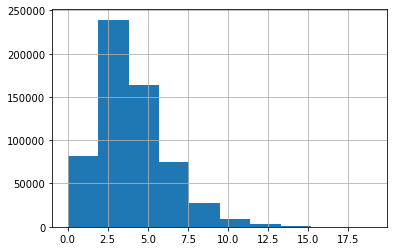

In [22]:
_ = wallets.num_sales.hist()

In [23]:
wallets.num_sales.agg(["min", "mean", "median", "max"]) 

min        0.000000
mean       3.767535
median     3.000000
max       19.000000
Name: num_sales, dtype: float64

In [24]:
sum(wallets.num_sales.isna())

572

In [25]:
wallets.num_sales.fillna(2, inplace=True)

## 莊惟翔 WIP

1. 限定數量為一(不算bundle) 2022/6/09

2. 將錢包地址分組

3. 暫時給定任一個錢包地址來進行以下特徵計算 (最後再用迴圈串起來)

_*Note to Fred:*_ 'quantity' has already been converted to float during the initial data load.

In [26]:
#2022/6/09
df_temp2 = wallets.drop(columns=["payment_token_usdprice", "asset_bundle","auction_type","transaction_hash", \
                       "block_hash","block_number","is_private","duration"])

#限定數量為一(不算bundle) 2022/6/09
df_temp2 = df_temp2[df_temp2['quantity'] == 1]
#將錢包地址分組
sectors = df_temp2.groupby("wallet_address_input")

#暫時給定任一個錢包地址來進行以下特徵計算 (最後再用迴圈串起來)
df_temp3 = sectors.get_group("0x5338035c008ea8c4b850052bc8dad6a33dc2206c")
df_temp3.reset_index(drop = True, inplace=True)
df_temp3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151 entries, 0 to 150
Data columns (total 21 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   event_timestamp                   151 non-null    datetime64[ns]
 1   event_type                        151 non-null    object        
 2   token_id                          151 non-null    object        
 3   num_sales                         151 non-null    float64       
 4   listing_time                      148 non-null    datetime64[ns]
 5   token_owner_address               151 non-null    object        
 6   token_seller_address              151 non-null    object        
 7   from_account_address              0 non-null      object        
 8   deal_price                        151 non-null    float64       
 9   payment_token_symbol              151 non-null    object        
 10  quantity                          151 non-null    

In [27]:
df_temp3.head()

,event_timestamp,event_type,token_id,num_sales,listing_time,token_owner_address,token_seller_address,from_account_address,deal_price,payment_token_symbol,...,created_date,collection_slug,contract_address,wallet_address_input,dev_fee_payment_event,dev_seller_fee_basis_points,transaction_from_account_address,transaction_to_account_address,winner_account_address,deal_price_usd
0,2021-08-06 23:01:37,buy,1228,7.0,2021-08-06 20:24:42,0xf4818c599e8848129770eeb6f70dd4ecfe029840,0x44266f38ea9ef4e85a77310518b1cb6d5a56349b,None,0.045,ETH,...,2021-08-06T23:02:21.077757,lazy-lions,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,0x5338035c008ea8c4b850052bc8dad6a33dc2206c,"{'asset': None, 'asset_bundle': None, 'event_t...",0.0,0x5338035c008ea8c4b850052bc8dad6a33dc2206c,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,0x5338035c008ea8c4b850052bc8dad6a33dc2206c,84.76065
1,2021-08-06 23:01:37,buy,6535,6.0,2021-08-06 22:55:33,0xfc8d1345e6f20c349939bc9113f3cc52af2cd153,0x958ae6e9b3dacba32f760a2cef018c765c3d3d3c,None,0.035,ETH,...,2021-08-06T23:02:17.730600,lazy-lions,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,0x5338035c008ea8c4b850052bc8dad6a33dc2206c,"{'asset': None, 'asset_bundle': None, 'event_t...",0.0,0x5338035c008ea8c4b850052bc8dad6a33dc2206c,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,0x5338035c008ea8c4b850052bc8dad6a33dc2206c,65.92495
2,2021-08-06 23:02:15,buy,7366,3.0,2021-08-06 22:54:18,0x5f9a8d61536cbdf444d081af741cc677b669ec2f,0x69b29647ddb42338e4af8b6912fbef2bb3d79884,None,0.035,ETH,...,2021-08-06T23:02:54.124565,lazy-lions,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,0x5338035c008ea8c4b850052bc8dad6a33dc2206c,"{'asset': None, 'asset_bundle': None, 'event_t...",0.0,0x5338035c008ea8c4b850052bc8dad6a33dc2206c,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,0x5338035c008ea8c4b850052bc8dad6a33dc2206c,65.92495
3,2021-08-06 23:06:14,buy,5372,8.0,2021-08-06 22:09:13,0x9888b9aad4d9738eca4ba5aee2021e9d0dc8d0bc,0x179d872918135cd08122a16f7e2d52ddc8db739d,None,0.049,ETH,...,2021-08-06T23:06:58.459110,lazy-lions,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,0x5338035c008ea8c4b850052bc8dad6a33dc2206c,"{'asset': None, 'asset_bundle': None, 'event_t...",0.0,0x5338035c008ea8c4b850052bc8dad6a33dc2206c,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,0x5338035c008ea8c4b850052bc8dad6a33dc2206c,92.29493
4,2021-08-06 23:07:30,buy,348,5.0,2021-08-06 21:37:17,0x01b60ad0b35a5ff854000520d3533578bff9200a,0xdec08cb92a506b88411da9ba290f3694be223c26,None,0.050,ETH,...,2021-08-06T23:07:51.179835,lazy-lions,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,0x5338035c008ea8c4b850052bc8dad6a33dc2206c,"{'asset': None, 'asset_bundle': None, 'event_t...",0.0,0x5338035c008ea8c4b850052bc8dad6a33dc2206c,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,0x5338035c008ea8c4b850052bc8dad6a33dc2206c,94.17850


In [28]:
#買入價格，給定以太鏈。Eth = deal_price/(10**18)
#df_temp3["cost"] = np.where(df_temp3["wallet_address_input"][0]==df_temp3["token_seller_address"], 0,df_temp3["deal_price"]/10**18)
df_temp3["cost"] = np.where(df_temp3["wallet_address_input"]==df_temp3["token_seller_address"], 0, df_temp3["deal_price"])
#賣出價格
#df_temp3["sellprice"] = np.where(df_temp3["wallet_address_input"][0]==df_temp3["token_seller_address"], df_temp3["deal_price"]/10**18, 0)
df_temp3["sellprice"] = np.where(df_temp3["wallet_address_input"]==df_temp3["token_seller_address"], df_temp3["deal_price"], 0)

## cost and sellprice probably aren't necessary since it can be infer from 'Buy_Sell' created below
## a deal_price_usd is recommended

#日期轉換
df_temp3["Datetime"] = pd.to_datetime(df_temp3["event_timestamp"]) # this can be stored in event_timestamp instead of a new column
#買賣戳記
# Consider overwriting event_type column
df_temp3["Buy_Sell"] = np.where(df_temp3["wallet_address_input"]==df_temp3["token_seller_address"], "S", 'B')
#投資組合(庫存) << what do we plan to store here?
df_temp3["Profolio"] = np.NaN
#損益 << Profit? How do we plan to calculate this for each row of event?
df_temp3["PL"] = 0
#token持有數量 << 
df_temp3["NFT_total_num"] = 0
#用collection_slug和tokenid組一個獨立欄位，用以紀錄錢包所持有的token
df_temp3["collection_slug_tokenid"] = df_temp3["collection_slug"] + df_temp3["token_id"]
#token從二級買進到賣出所持有的時間
df_temp3["HoldPeriod"] = np.NaN
df_temp3["Position"] = 0
df_temp3["Sell"] = 0

C:\Users\lawrence\AppData\Local\Temp\ipykernel_47568\2091787877.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp3["cost"] = np.where(df_temp3["wallet_address_input"]==df_temp3["token_seller_address"], 0, df_temp3["deal_price"])
C:\Users\lawrence\AppData\Local\Temp\ipykernel_47568\2091787877.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp3["sellprice"] = np.where(df_temp3["wallet_address_input"]==df_temp3["token_seller_address"], df_temp3["deal_price"], 0)
C:\Users\lawrence\AppData\Loc

In [29]:
df_temp3.iloc[:,15:].head()

,dev_fee_payment_event,dev_seller_fee_basis_points,transaction_from_account_address,transaction_to_account_address,winner_account_address,deal_price_usd,cost,sellprice,Datetime,Buy_Sell,Profolio,PL,NFT_total_num,collection_slug_tokenid,HoldPeriod,Position,Sell
0,"{'asset': None, 'asset_bundle': None, 'event_t...",0.0,0x5338035c008ea8c4b850052bc8dad6a33dc2206c,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,0x5338035c008ea8c4b850052bc8dad6a33dc2206c,84.76065,0.045,0.0,2021-08-06 23:01:37,B,NaN,0,0,lazy-lions1228,NaN,0,0
1,"{'asset': None, 'asset_bundle': None, 'event_t...",0.0,0x5338035c008ea8c4b850052bc8dad6a33dc2206c,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,0x5338035c008ea8c4b850052bc8dad6a33dc2206c,65.92495,0.035,0.0,2021-08-06 23:01:37,B,NaN,0,0,lazy-lions6535,NaN,0,0
2,"{'asset': None, 'asset_bundle': None, 'event_t...",0.0,0x5338035c008ea8c4b850052bc8dad6a33dc2206c,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,0x5338035c008ea8c4b850052bc8dad6a33dc2206c,65.92495,0.035,0.0,2021-08-06 23:02:15,B,NaN,0,0,lazy-lions7366,NaN,0,0
3,"{'asset': None, 'asset_bundle': None, 'event_t...",0.0,0x5338035c008ea8c4b850052bc8dad6a33dc2206c,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,0x5338035c008ea8c4b850052bc8dad6a33dc2206c,92.29493,0.049,0.0,2021-08-06 23:06:14,B,NaN,0,0,lazy-lions5372,NaN,0,0
4,"{'asset': None, 'asset_bundle': None, 'event_t...",0.0,0x5338035c008ea8c4b850052bc8dad6a33dc2206c,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,0x5338035c008ea8c4b850052bc8dad6a33dc2206c,94.17850,0.050,0.0,2021-08-06 23:07:30,B,NaN,0,0,lazy-lions348,NaN,0,0


In [30]:
df_temp3.iloc[:,15:].tail()

,dev_fee_payment_event,dev_seller_fee_basis_points,transaction_from_account_address,transaction_to_account_address,winner_account_address,deal_price_usd,cost,sellprice,Datetime,Buy_Sell,Profolio,PL,NFT_total_num,collection_slug_tokenid,HoldPeriod,Position,Sell
146,None,NaN,None,None,None,6646.9522,0.0,2.78,2021-10-15 01:15:36,S,NaN,0,0,kaiju-kingz575,NaN,0,0
147,None,NaN,None,None,None,6886.0512,0.0,2.88,2021-10-15 01:21:24,S,NaN,0,0,kaiju-kingz576,NaN,0,0
148,None,NaN,None,None,None,6646.9522,0.0,2.78,2021-10-15 01:23:33,S,NaN,0,0,kaiju-kingz579,NaN,0,0
149,None,NaN,None,None,None,15923.9934,0.0,6.66,2021-10-15 02:26:47,S,NaN,0,0,kaiju-kingz583,NaN,0,0
150,None,NaN,None,None,None,10089.9778,0.0,4.22,2021-10-15 03:02:59,S,NaN,0,0,kaiju-kingz577,NaN,0,0


Is the code block below attempting to calculate the _current cumulative stat_ of each wallet?

In [31]:
porfolio_dict = {}#紀錄持有的NFT集合
porfolio_costdict = {}#紀錄買入成本
porfolio_datedict = {}#紀錄買入時間
count = 0
error = []
#資料時間是從新到舊，計算時要倒序，從舊到新去累計上來。
for i in range(len(df_temp3)-1,-1,-1):
    #初次買進NFT項目
    if df_temp3["collection_slug"][i] not in porfolio_dict.keys():
        if df_temp3["Buy_Sell"][i]=="B":
            #庫存加一
            count = count+1
            porfolio_dict[df_temp3["collection_slug"][i]] = [df_temp3["token_id"][i]]
            df_temp3.loc[i, "Profolio"] = [porfolio_dict]
            df_temp3.loc[i, "NFT_total_num"] = count
            #NFT成本
            porfolio_costdict[df_temp3["collection_slug_tokenid"][i]] = df_temp3["cost"][i]
            #NFT買進時間
            porfolio_datedict[df_temp3["collection_slug_tokenid"][i]] = df_temp3["Datetime"][i]
            #position
            df_temp3.loc[i, "Position"] = sum(porfolio_costdict.values())
            
        else:
            #賣出代表過去有可能發生來自於其他錢包轉移，但無法計算到先前持有的成本。
            df_temp3.loc[i, "NFT_total_num"] = count
            df_temp3.loc[i, "Position"] = sum(porfolio_costdict.values())
    else:
        #手上持有此項目的NFT
        if df_temp3["token_id"][i] not in porfolio_dict[df_temp3["collection_slug"][i]]:
            if df_temp3["Buy_Sell"][i]=="B":
                #買進加碼
                porfolio_dict[df_temp3["collection_slug"][i]].append(df_temp3["token_id"][i])
                df_temp3.loc[i, "Profolio"] = [porfolio_dict]
                #庫存加一
                count = count+1
                df_temp3.loc[i, "NFT_total_num"] = count
                #NFT成本
                porfolio_costdict[df_temp3["collection_slug_tokenid"][i]] = df_temp3["cost"][i]
                #NFT買進時間
                porfolio_datedict[df_temp3["collection_slug_tokenid"][i]] = df_temp3["Datetime"][i]
                #position
                df_temp3.loc[i, "Position"] = sum(porfolio_costdict.values())
                
            else:
                #賣出。有可能發生來自於其他錢包轉移，但無法計算到先前持有的成本。
                df_temp3.loc[i, "NFT_total_num"] = count
                df_temp3.loc[i, "Profolio"] = [porfolio_dict]
                df_temp3.loc[i, "Position"] = sum(porfolio_costdict.values())
        else:
            if df_temp3["Buy_Sell"][i]=="B":
                #不可能發生，因為tokenid是唯一的?
                df_temp3.loc[i, "NFT_total_num"] = count
                df_temp3.loc[i, "Profolio"] = [porfolio_dict]
                df_temp3.loc[i, "Position"] = sum(porfolio_costdict.values())
            else:
                #損益發生點，完成一次買入跟賣出
                #庫存減一
                count = count-1
                df_temp3.loc[i, "NFT_total_num"] = count
                #將token從porfolio移除
                porfolio_dict[df_temp3["collection_slug"][i]].remove(df_temp3["token_id"][i])
                df_temp3.loc[i, "Profolio"] = [porfolio_dict]
                if df_temp3["collection_slug_tokenid"][i] in porfolio_costdict.keys():
                    profit = df_temp3["sellprice"][i] - porfolio_costdict[df_temp3["collection_slug_tokenid"][i]]
                    df_temp3.loc[i, "PL"] =  profit        
                    #丟棄key and value因為賣出了
                    porfolio_costdict.pop(df_temp3["collection_slug_tokenid"][i])
                    df_temp3.loc[i, "Position"] = sum(porfolio_costdict.values())
                    #TOKEN從買入到賣出持有間隔時間
                    date_substrate = df_temp3["Datetime"][i] - porfolio_datedict[df_temp3["collection_slug_tokenid"][i]]
                    df_temp3.loc[i, "HoldPeriod"] =  date_substrate
                    #賣出戳記
                    df_temp3.loc[i, "Sell"] =  1
                    
                else:
                    #通常不會到這裡
                    error.append([df_temp3["wallet_address_input"][0],df_temp3["collection_slug_tokenid"][i]])
                    df_temp3.loc[i, "Profolio"] = [porfolio_dict]
                    df_temp3.loc[i, "Position"] = sum(porfolio_costdict.values())

C:\Users\lawrence\AppData\Local\Temp\ipykernel_47568\2146049416.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp3.loc[i, "Profolio"] = [porfolio_dict]
C:\Users\lawrence\AppData\Local\Temp\ipykernel_47568\2146049416.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp3.loc[i, "Position"] = sum(porfolio_costdict.values())


In [32]:
#損益為正
def positive_SIGN(row):
    if row['PL_sign'] == 1:
        return 1
    return 0

#損益為負
def negative_SIGN(row):
    if row['PL_sign'] == -1 :
        return 1
    return 0

In [33]:
#累計損益是在一個錢包裡完成完整的買進賣出動作所累計的。
df_temp3['cum_PL'] = df_temp3.loc[::-1, 'PL'].cumsum()[::-1]
#總利潤
df_temp3['TotalRevenue'] = df_temp3['cum_PL'] - df_temp3["Position"]
#損益正負符號
df_temp3["PL_sign"] = np.sign(list(df_temp3["PL"].values))
#累計賣出數量
df_temp3["cum_Sell"] = df_temp3.loc[::-1, 'Sell'].cumsum()[::-1]
#損益為正做記號
df_temp3["positive_sign"] = df_temp3.apply(lambda row: positive_SIGN(row), axis=1)
#損益為負做記號
df_temp3["negative_sign"] = df_temp3.apply(lambda row: negative_SIGN(row), axis=1)
#累積正損益數
df_temp3["cum_positive_sign"] = df_temp3.loc[::-1, 'positive_sign'].cumsum()[::-1]
#累積負損益數
df_temp3["cum_negative_sign"] = df_temp3.loc[::-1, 'negative_sign'].cumsum()[::-1]
#勝率
df_temp3["winrate"] = df_temp3["cum_positive_sign"] / df_temp3['cum_Sell']
#輸錢率
df_temp3["lossrate"] = df_temp3["cum_negative_sign"] / df_temp3['cum_Sell']
#用0填補缺值
df_temp3["winrate"] = df_temp3["winrate"].fillna(0)
df_temp3["lossrate"] = df_temp3["lossrate"].fillna(0)
#接受問價而賣出做紀號
df_temp3["Bid_sell"] = np.where((df_temp3["payment_token_symbol"]=="WETH")&(df_temp3["Buy_Sell"]=="S"), 1,0)
#透過問價而買入做紀號
df_temp3["Bid_buy"] = np.where((df_temp3["payment_token_symbol"]=="WETH")&(df_temp3["Buy_Sell"]=="B"), 1,0)
#累計問價買入數
df_temp3["cum_Bid_buy"] = df_temp3.loc[::-1, 'Bid_buy'].cumsum()[::-1]
#累計接受問價賣出數
df_temp3["cum_Bid_sell"] = df_temp3.loc[::-1, 'Bid_sell'].cumsum()[::-1]

#勝率(透過問價而買入&接受問價而賣出)前者代表很會釣魚，後者代表失去信心或是無法抵抗高價誘惑
df_temp3["Bid_sell_rate"] = df_temp3["cum_Bid_sell"] / df_temp3["cum_Sell"]
df_temp3["Bid_sell_rate"] = df_temp3["Bid_sell_rate"].fillna(0)
df_temp3["Bid_buy_rate"] = df_temp3["cum_Bid_buy"] / df_temp3["NFT_total_num"]
df_temp3["Bid_buy_rate"] = df_temp3["Bid_buy_rate"].fillna(0) #2022/06/09
#TOKEN賣出數/手上TOKEN持有數
df_temp3["sellposition_rate"] = df_temp3["cum_Sell"]/df_temp3["NFT_total_num"]

C:\Users\lawrence\AppData\Local\Temp\ipykernel_47568\333410565.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp3['cum_PL'] = df_temp3.loc[::-1, 'PL'].cumsum()[::-1]
C:\Users\lawrence\AppData\Local\Temp\ipykernel_47568\333410565.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp3['TotalRevenue'] = df_temp3['cum_PL'] - df_temp3["Position"]
C:\Users\lawrence\AppData\Local\Temp\ipykernel_47568\333410565.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [34]:
df_temp3.describe().loc["mean"]

c:\Users\lawrence\anaconda3\envs\Blockchain\lib\site-packages\numpy\lib\function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


num_sales                         3.629139
deal_price                        1.800025
quantity                          1.000000
dev_seller_fee_basis_points       0.000000
deal_price_usd                 4286.956765
cost                              0.334172
sellprice                         1.465853
PL                                0.000000
NFT_total_num                     9.953642
HoldPeriod                             NaN
Position                         34.261424
Sell                              0.000000
cum_PL                            0.000000
TotalRevenue                    -34.261424
PL_sign                           0.000000
cum_Sell                          0.000000
positive_sign                     0.000000
negative_sign                     0.000000
cum_positive_sign                 0.000000
cum_negative_sign                 0.000000
winrate                           0.000000
lossrate                          0.000000
Bid_sell                          0.019868
Bid_buy    

## Create features

In [35]:
wallets.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600856 entries, 4436 to 14354
Data columns (total 29 columns):
 #   Column                            Non-Null Count   Dtype          
---  ------                            --------------   -----          
 0   event_timestamp                   600856 non-null  datetime64[ns] 
 1   event_type                        600856 non-null  object         
 2   token_id                          600284 non-null  object         
 3   num_sales                         600856 non-null  float64        
 4   listing_time                      554455 non-null  datetime64[ns] 
 5   token_owner_address               600284 non-null  object         
 6   token_seller_address              600856 non-null  object         
 7   from_account_address              233 non-null     object         
 8   deal_price                        600731 non-null  float64        
 9   payment_token_symbol              600705 non-null  object         
 10  payment_token_usdp

### wallet age

In [36]:
grp=wallets.rename(columns={"wallet_address_input": "user_account_address"}) \
    .groupby("user_account_address")
grp.agg({"event_timestamp": [max, min]}) \
    .assign(age=lambda x : x.loc[:, ("event_timestamp", "max")] - x.loc[:, ("event_timestamp", "min")]) \
    .sort_values(by=["age", ("event_timestamp", "min")])

event_timestamp  \
                                                           max   
user_account_address                                             
0x6a5230f88106d77151d715e4df95009c3581bb3a 2021-05-01 01:07:13   
0x90738f6cef16c06dfb430bdd44426be23bb75aab 2021-05-01 04:25:49   
0xdc69232a4d11979c6ce1b71e31bcd6d3854d02f0 2021-05-01 06:40:50   
0x9a592ce6dae5759d0e730069829e965bdfe04196 2021-05-01 07:04:40   
0x3d47ecd659f2308731a33792761375c1f82f1228 2021-05-01 07:26:11   
...                                                        ...   
0x2ef1b2567aa33e1ba07f4fbd1a297223df28bafa 2022-05-29 14:11:23   
0xc7d430d97b86fad363139f98874ffc2eeb582fdd 2022-05-28 00:44:31   
0x2718a8b3e39f799970d07d72faf178d0f6abce3a 2022-05-31 21:14:12   
0xcf474bd551eb74d765451ec654022b147dc1a312 2022-06-01 01:42:06   
0x56178626332fc530561535eeaa914b863aa455f2 2022-06-03 17:58:49   

                                                                \
                                                           min   
user_account_address                                             
0x6a5230f88106d77151d715e4df95009c3581bb3a 2021-05-01 01:07:13   
0x90738f6cef16c06dfb430bdd44426be23bb75aab 2021-05-01 04:25:49   
0xdc69232a4d11979c6ce1b71e31bcd6d3854d02f0 2021-05-01 06:40:50   
0x9a592ce6dae5759d0e730069829e965bdfe04196 2021-05-01 07:04:40   
0x3d47ecd659f2308731a33792761375c1f82f1228 2021-05-01 07:26:11   
...                                                        ...   
0x2ef1b2567aa33e1ba07f4fbd1a297223df28bafa 2021-05-05 19:31:27   
0xc7d430d97b86fad363139f98874ffc2eeb582fdd 2021-05-01 11:20:36   
0x2718a8b3e39f799970d07d72faf178d0f6abce3a 2021-05-02 03:46:44   
0xcf474bd551eb74d765451ec654022b147dc1a312 2021-05-01 21:09:20   
0x56178626332fc530561535eeaa914b863aa455f2 2021-05-03 20:31:36   

                                                         age  
                                                              
user_account_address                                          
0x6a5230f88106d77151d715e4df95009c3581bb3a   0 days 00:00:00  
0x90738f6cef16c06dfb430bdd44426be23bb75aab   0 days 00:00:00  
0xdc69232a4d11979c6ce1b71e31bcd6d3854d02f0   0 days 00:00:00  
0x9a592ce6dae5759d0e730069829e965bdfe04196   0 days 00:00:00  
0x3d47ecd659f2308731a33792761375c1f82f1228   0 days 00:00:00  
...                                                      ...  
0x2ef1b2567aa33e1ba07f4fbd1a297223df28bafa 388 days 18:39:56  
0xc7d430d97b86fad363139f98874ffc2eeb582fdd 391 days 13:23:55  
0x2718a8b3e39f799970d07d72faf178d0f6abce3a 394 days 17:27:28  
0xcf474bd551eb74d765451ec654022b147dc1a312 395 days 04:32:46  
0x56178626332fc530561535eeaa914b863aa455f2 395 days 21:27:13  

[120178 rows x 3 columns]

_Do we ingore wallet age is 0 and over x months old?_

### `duration_mean` average time to complete sales (or purchase)

In [37]:
wallets.groupby('wallet_address_input')['duration'].mean().sort_values()

wallet_address_input
0xb1561ac1cac5b004b33af590f2f34b1a6c928ccc   -1 days +23:59:19.801515
0x094dece09096d5d6e3da2baef3ecbb0e9e7ea9df   -1 days +23:59:26.694787
0xdead29f8b16e288c18110b460f59f24d502f4007   -1 days +23:59:29.889599
0xa8a8a9d77568d922a1e47e6ed5fb67e8499a29ad   -1 days +23:59:50.338247
0x96befe6a41a15a8108dc5933fa068d6c4bce0278   -1 days +23:59:50.338247
                                                       ...           
0x5b6fd849e24d6e47f887243d28413d3e6b848313          151 days 21:04:46
0xd4a41b4ef1cf0acdd2b857965f4b294686aeff98          156 days 09:34:02
0x4fdb083fb94a17dae87acfd09f8d401395743528          156 days 23:54:19
0x113743fb8c42946ff50c7c91fd7626d2a1ce5b7e          164 days 07:29:39
0x2fc8f3b6f001b9082f0253ac7d6d905db06b13cd          172 days 00:12:22
Name: duration, Length: 120178, dtype: timedelta64[ns]

### `duration_colection_mean` average time to complete sales (or purchase) by collection

In [38]:
wallets.groupby(['wallet_address_input', 'collection_slug'])['duration'].mean().sort_values()

wallet_address_input                        collection_slug      
0xb1561ac1cac5b004b33af590f2f34b1a6c928ccc  karafuru                -1 days +23:59:19.801515
0x094dece09096d5d6e3da2baef3ecbb0e9e7ea9df  karafuru                -1 days +23:59:26.694787
0xdead29f8b16e288c18110b460f59f24d502f4007  karafuru                -1 days +23:59:29.889599
0xafbf7e3cfa48ff03dca13472b86397f77c190d7c  world-of-women-nft      -1 days +23:59:37.500917
0xcad7fc974f61a08adef110d1ba446fa5b5b5bb27  mutant-ape-yacht-club   -1 days +23:59:44.644174
                                                                              ...           
0x7daf36b02586e7a30118e1648b36346194490b64  bored-ape-kennel-club          216 days 16:07:06
0x18994eeb0d074446ff2646d900395d5038773f37  bored-ape-kennel-club          218 days 02:33:45
0x2fc8f3b6f001b9082f0253ac7d6d905db06b13cd  meebits                        233 days 00:50:05
0xbb372b06aaeef2a869d4519c92658a2a6a493c07  meebits                        233 days 00:50:05
0x5d

### `num_nft_curr` currently the number of NFT on-hand by collection

In [39]:
_ = wallets.loc[:, ['wallet_address_input', 'event_type', 'collection_slug', 'token_id', 'quantity']]
_.quantity = np.where(_.event_type == 'buy', -_.quantity, _.quantity)
_ = _.rename(columns={'wallet_address_input': 'user_account_address'}) \
    .groupby(['user_account_address', 'collection_slug'])['quantity'].sum()
_[_ < 1]

user_account_address                        collection_slug      
0x000000000004d7463d0f9c77383600bc82d612f5  doodles-official        -2.0
                                            mfers                   -1.0
0x000000000006b92d1ca16b6e55071e8b5626d5d6  cryptoadz-by-gremplin   -8.0
                                            meebits                 -1.0
                                            world-of-women-nft      -1.0
                                                                    ... 
0xfffcde6975788ff3c5ad6bc5d00c3fbc9d42483c  cool-cats-nft           -1.0
0xfffd07733a5554c401abc4f1a1cdfd2c6389ceef  lazy-lions               0.0
0xfffd50693ccbfe73892da30c1213a351f3e1775c  mutant-ape-yacht-club    0.0
0xfffd59651b59eb34bdffc11bfdb9de67fa4167d2  phantabear               0.0
0xfffda1f24f612ece7a90d1d59af82508ed69b23c  cyberkongz-vx           -1.0
Name: quantity, Length: 136697, dtype: float64

We drop data anomaly where current number is less than 1, or should we make impute them to `0`?

In [40]:
_ = _[_ >= 1]
_

user_account_address                        collection_slug  
0x0000000000015b23c7e20b0ea5ebd84c39dcbe60  boredapeyachtclub     2.0
0x000000000004d7463d0f9c77383600bc82d612f5  mekaverse             1.0
0x00000000009a41862f3b2b0c688b7c0d1940511e  cyberkongz-vx        24.0
                                            karafuru              8.0
0x000000000ad266ec3db44bbe580e87f9baa358e6  cool-cats-nft         1.0
                                                                 ... 
0xfffba6475d0aa8046e27275f26f4b467566b7868  proof-moonbirds       1.0
0xfffcde6975788ff3c5ad6bc5d00c3fbc9d42483c  coolpetsnft           1.0
0xfffe1ad6839d86df413c4a10de465a00a0739048  mekaverse             2.0
0xffffc32855b2620c86f413065af8c58ec68d474d  coolpetsnft           2.0
                                            meebits               1.0
Name: quantity, Length: 60644, dtype: float64

### `num_collect_curr` currently the number of collections on-hand

In [41]:
_.groupby('user_account_address').size()

user_account_address
0x0000000000015b23c7e20b0ea5ebd84c39dcbe60    1
0x000000000004d7463d0f9c77383600bc82d612f5    1
0x00000000009a41862f3b2b0c688b7c0d1940511e    2
0x000000000ad266ec3db44bbe580e87f9baa358e6    3
0x000000105de91f6c9b8c7d56d16258461ddaec1d    1
                                             ..
0xfffb264bf1275e5ccb5444366a782eb89045515c    3
0xfffba6475d0aa8046e27275f26f4b467566b7868    1
0xfffcde6975788ff3c5ad6bc5d00c3fbc9d42483c    1
0xfffe1ad6839d86df413c4a10de465a00a0739048    1
0xffffc32855b2620c86f413065af8c58ec68d474d    2
Name: quantity, Length: 46240, dtype: int64

### `num_event_contracts`

How do we make use of this feature?

In [42]:
wallets.groupby('wallet_address_input')[['contract_address', 'collection_slug']].nunique().sort_values('contract_address')

,contract_address,collection_slug
wallet_address_input,,
0x0000000000015b23c7e20b0ea5ebd84c39dcbe60,1,1
0xa3c4c775b761f0a2c12856b05ecd124b142d7f55,1,1
0xa3c318cd2ec22fc8793e7cbd4bcd849a4ffd28ef,1,1
0xa3c2651881d2081831d534f1e87593f7e926bd6a,1,1
0xa3c0338854487cb16eb2c4fd5996d34721759c70,1,1
...,...,...
0xa1a18c3558365c098ad1306075d8ac9b9ab78219,3,10
0x33e3c007d1d48e2b645c9ce22570267b0c82f578,3,11
0xd595710aedaba1d2e18bfdbab46ab796664c6d89,3,13


### `cumnum_nft_month` pd.DataFrame.cumsum by Month (TODO)

### `duration_held` and `endurance_rank`

In [43]:
_ = wallets.loc[:, ['wallet_address_input', 'event_timestamp', 'event_type', 'collection_slug', 'token_id']]
#_['nft_id'] = _.collection_slug + '-' + _.token_id
_ = _.pivot_table(index=['wallet_address_input', 'collection_slug', 'token_id'],
                  columns='event_type', values='event_timestamp',
                  aggfunc=['min', 'max']) \
    .dropna() \
    .assign(duration_held=lambda x: x[('max', 'sell')] - x[('min', 'buy')])
_

min  \
event_type                                                                                buy   
wallet_address_input                       collection_slug       token_id                       
0x000000000004d7463d0f9c77383600bc82d612f5 doodles-official      6103     2021-11-16 17:47:16   
                                                                 6890     2021-11-14 14:13:31   
                                                                 7228     2021-10-22 20:31:40   
                                                                 9521     2021-11-24 08:53:06   
0x000000005692889cb391feb2095cb025c24b2210 azuki                 1884     2022-05-06 06:28:36   
...                                                                                       ...   
0xfffbed6df8f0a624dfa821a9e3bb9c51bd05f8da invisiblefriends      4378     2022-02-24 11:25:33   
0xfffcde6975788ff3c5ad6bc5d00c3fbc9d42483c coolpetsnft           16912    2022-03-01 08:35:16   
0xfffd07733a5554c401abc4f1a1cdfd2c6389ceef lazy-lions            6151     2021-08-10 15:47:06   
0xfffd50693ccbfe73892da30c1213a351f3e1775c mutant-ape-yacht-club 7458     2021-10-23 14:41:19   
0xfffd59651b59eb34bdffc11bfdb9de67fa4167d2 phantabear            1007     2022-03-24 12:08:16   

                                                                                               \
event_type                                                                               sell   
wallet_address_input                       collection_slug       token_id                       
0x000000000004d7463d0f9c77383600bc82d612f5 doodles-official      6103     2021-11-24 07:32:01   
                                                                 6890     2021-11-16 21:53:21   
                                                                 7228     2021-11-14 09:27:10   
                                                                 9521     2021-12-29 07:06:49   
0x000000005692889cb391feb2095cb025c24b2210 azuki                 1884     2022-05-10 17:51:04   
...                                                                                       ...   
0xfffbed6df8f0a624dfa821a9e3bb9c51bd05f8da invisiblefriends      4378     2022-02-27 17:20:05   
0xfffcde6975788ff3c5ad6bc5d00c3fbc9d42483c coolpetsnft           16912    2022-03-28 06:26:32   
0xfffd07733a5554c401abc4f1a1cdfd2c6389ceef lazy-lions            6151     2021-08-11 19:48:13   
0xfffd50693ccbfe73892da30c1213a351f3e1775c mutant-ape-yacht-club 7458     2021-12-31 09:21:24   
0xfffd59651b59eb34bdffc11bfdb9de67fa4167d2 phantabear            1007     2022-05-23 10:28:40   

                                                                                          max  \
event_type                                                                                buy   
wallet_address_input                       collection_slug       token_id                       
0x000000000004d7463d0f9c77383600bc82d612f5 doodles-official      6103     2021-11-16 17:47:16   
                                                                 6890     2021-11-14 14:13:31   
                                                                 7228     2021-10-22 20:31:40   
                                                                 9521     2021-11-24 08:53:06   
0x000000005692889cb391feb2095cb025c24b2210 azuki                 1884     2022-05-06 06:28:36   
...                                                                                       ...   
0xfffbed6df8f0a624dfa821a9e3bb9c51bd05f8da invisiblefriends      4378     2022-02-24 11:25:33   
0xfffcde6975788ff3c5ad6bc5d00c3fbc9d42483c coolpetsnft           16912    2022-03-01 08:35:16   
0xfffd07733a5554c401abc4f1a1cdfd2c6389ceef lazy-lions            6151     2021-08-10 15:47:06   
0xfffd50693ccbfe73892da30c1213a351f3e1775c mutant-ape-yacht-club 7458     2021-10-23 14:41:19   
0xfffd59651b59eb34bdffc11bfdb9de67fa4167d2 phantabear            1007     2022-03-24 12:08:16   

             

In [44]:
x = _.groupby('wallet_address_input')['duration_held'] \
    .agg(['size', 'mean'])
x

,size,mean
wallet_address_input,,
0x000000000004d7463d0f9c77383600bc82d612f5,4,16 days 20:08:27
0x000000005692889cb391feb2095cb025c24b2210,1,4 days 11:22:28
0x000000070f91b6c56fa08d4f3a26c7fc992b38f4,3,42 days 15:31:44
0x0000000dbf80f29c9ed7d52116f3037f8deb1902,3,4 days 14:36:59.333333333
0x000000105de91f6c9b8c7d56d16258461ddaec1d,1,4 days 18:21:14
...,...,...
0xfffbed6df8f0a624dfa821a9e3bb9c51bd05f8da,2,16 days 03:24:54.500000
0xfffcde6975788ff3c5ad6bc5d00c3fbc9d42483c,1,26 days 21:51:16
0xfffd07733a5554c401abc4f1a1cdfd2c6389ceef,1,1 days 04:01:07


Data anomaly - excluding these wallets

In [45]:
x[x['mean'] < pd.Timedelta(0)]

,size,mean
wallet_address_input,,
0x04d253fbdd4501c383e35dea2663a053b7439904,1,-1 days +23:36:05
0x0eea3ebb6943dcff080f7fe807f990b143d2c8cd,1,-1 days +23:34:26
0x1e3882aff34c1eaf5507e77026f215085bda1e19,1,-5 days +16:45:32
0x27eb3947d5c209e25fbd7d0cf77fedb52f8d482e,1,-9 days +03:42:38
0x375a2a5b4a57b710cb43e0d364d872c3a8138579,1,-1 days +23:53:00
0x4fd835b2dda525e6052b4c378e03195715685684,1,-1 days +08:46:37
0x60676e210d3117ce849c858b1eba42cdaa8d8949,1,-1 days +18:58:23
0x744715fbf1e5cfa4549c19ea75938277be3f61e4,1,-19 days +23:33:00
0x89bde316a5aa59d9995fc82b217308abae60257c,1,-2 days +15:11:11


In [46]:
x[x['mean'] > pd.Timedelta(0)] \
    .assign(endurance_rank=lambda x: x['mean'].rank(pct=True)) \
    .sort_values('endurance_rank', ascending=False)

,size,mean,endurance_rank
wallet_address_input,,,
0xa0206ac75aa347327f8ca82440279bd6a0fdef27,1,380 days 08:10:42,1.000000
0x856565db827588a88780454863f98a4a323e13aa,1,368 days 06:41:28,0.999979
0x057c2d080d30306ec2bf7ae15232fbe96627b066,1,366 days 23:55:38,0.999958
0x9b3e7f46e4e8894d4bc84bb3200161cc6f0fa0f2,1,346 days 17:52:22,0.999937
0xfcbca52b23db28470eb97680d18e988d8b60b608,1,343 days 13:47:20,0.999916
...,...,...,...
0x7eab2a69cb7f54aa502f9b9c6a99f4d0fc4b679a,1,0 days 00:01:25,0.000105
0xbf2c8b554a1d227f41eac0e6f50fe5700e9eac8d,1,0 days 00:01:24,0.000084
0x3d3cffda99793fd745afb67e240f47966d452ce0,1,0 days 00:01:22,0.000063


\* _How do we account for wallets that had made few trade but long hold time?_

### _buy_ vs _sell_ to date

- The total number aka __count__ of transactions and the quantity aka __sum__ of NFT
- The median and the total amount of transactions in USD

In [47]:
df = wallets.rename(columns={"wallet_address_input": "user_account_address"}) \
    .loc[:, ["user_account_address", "event_type", "quantity", "deal_price_usd"]] \
    .pivot_table(index="user_account_address",
                 columns="event_type",
                 values=["quantity", "deal_price_usd"],
                 aggfunc={"quantity": ["count", "sum"], "deal_price_usd": ["median", "sum"]},
                 fill_value=0)
df

deal_price_usd              \
                                                   median               
event_type                                            buy        sell   
user_account_address                                                    
0x0000000000015b23c7e20b0ea5ebd84c39dcbe60        0.00000   8918.1000   
0x000000000004d7463d0f9c77383600bc82d612f5     3790.61400   5187.1560   
0x000000000006b92d1ca16b6e55071e8b5626d5d6     2492.18520      0.0000   
0x00000000000a93ddd65c4daa1d7160f2207842c4     4917.66800      0.0000   
0x00000000002763419d1c9adda5df54f13d63e29b     3601.62000      0.0000   
...                                                   ...         ...   
0xfffd50693ccbfe73892da30c1213a351f3e1775c     6890.30199  21776.0400   
0xfffd59651b59eb34bdffc11bfdb9de67fa4167d2     3768.53790   3577.9720   
0xfffda1f24f612ece7a90d1d59af82508ed69b23c     2258.96250      0.0000   
0xfffe1ad6839d86df413c4a10de465a00a0739048        0.00000    683.1363   
0xffffc32855b2620c86f413065af8c58ec68d474d        0.00000   2376.9999   

                                                                     quantity  \
                                                     sum                count   
event_type                                           buy        sell      buy   
user_account_address                                                            
0x0000000000015b23c7e20b0ea5ebd84c39dcbe60      0.000000  17836.2000        0   
0x000000000004d7463d0f9c77383600bc82d612f5  42269.136714  35512.0680        7   
0x000000000006b92d1ca16b6e55071e8b5626d5d6  28346.932762      0.0000       10   
0x00000000000a93ddd65c4daa1d7160f2207842c4  14401.742000      0.0000        3   
0x00000000002763419d1c9adda5df54f13d63e29b  28336.275000      0.0000        4   
...                                                  ...         ...      ...   
0xfffd50693ccbfe73892da30c1213a351f3e1775c   6890.301990  21776.0400        1   
0xfffd59651b59eb34bdffc11bfdb9de67fa4167d2   7537.075800   7155.9440        2   
0xfffda1f24f612ece7a90d1d59af82508ed69b23c   2258.962500      0.0000        1   
0xfffe1ad6839d86df413c4a10de465a00a0739048      0.000000   1366.2726        0   
0xffffc32855b2620c86f413065af8c58ec68d474d      0.000000  22209.3425        0   

                                                          
                                                sum       
event_type                                 sell buy sell  
user_account_address                                      
0x0000000000015b23c7e20b0ea5ebd84c39dcbe60    2   0    2  
0x000000000004d7463d0f9c77383600bc82d612f5    5   7    5  
0x000000000006b92d1ca16b6e55071e8b5626d5d6    0  10    0  
0x00000000000a93ddd65c4daa1d7160f2207842c4    0   3    0  
0x00000000002763419d1c9adda5df54f13d63e29b    0   4    0  
...                                         ...  ..  ...  
0xfffd50693ccbfe73892da30c1213a351f3e1775c    1   1    1  
0xfffd59651b59eb34bdffc11bfdb9de67fa4167d2    2   2    2  
0xfffda1f24f612ece7a90d1d59af82508ed69b23c    0   1    0  
0xfffe1ad6839d86df413c4a10de465a00a0739048    2   0    2  
0xffffc32855b2620c86f413065af8c58ec68d474d    3   0    3  

[120178 rows x 8 columns]

Examples which user had _bundled_ multitple NFTs in a transaction

In [48]:
df[ df[("quantity", "sum", "sell")] > df[("quantity", "count", "sell")] ].loc[:, "quantity"]

count      sum     
event_type                                   buy sell buy sell
user_account_address                                          
0x004ec4b1f2e3355c34fb83cc0aec7bb375097d14     0    1   0    4
0x0114347b343c2a1b2f9207d7fe3f6fd606f627c7     0    3   0    6
0x012b38ccb3ae97a32cd24088bf9426d4ee5442d3    90  187  90  191
0x0395ea9aa8805bc0c05dbaf705ba4242e370601c     3    5   3    6
0x03d620f921e76725c4b9fb335f53b95545966312     0    2   0    3
...                                          ...  ...  ..  ...
0xfb796d6335a7ebcc4be5eb38111df1ecc0c8f299    24   34  24   35
0xfbe5c1ab13e206688775f117a9a90153d7fdcfd2     0    7   0    8
0xfc64410a03b205b995a9101f99a55026d8f1f1da     4    3   4    4
0xfc75d453446061c649b6b95955c525cccae95fd9     0    3   0    4
0xff18298382948028f9d93c4e32be1382204022c8     1    2   1   18

[238 rows x 4 columns]

Another example showing the transaction history

In [49]:
wallets.set_index("wallet_address_input") \
    .loc["0x0004ff7e7217dc672874fece2c7588581e97b1a7",
    ["event_timestamp", "event_type", "quantity"]].sort_values("event_timestamp")

,event_timestamp,event_type,quantity
wallet_address_input,,,
0x0004ff7e7217dc672874fece2c7588581e97b1a7,2021-08-31 14:24:37,buy,1.0
0x0004ff7e7217dc672874fece2c7588581e97b1a7,2021-09-09 13:19:26,buy,1.0
0x0004ff7e7217dc672874fece2c7588581e97b1a7,2021-09-09 18:42:46,sell,1.0
0x0004ff7e7217dc672874fece2c7588581e97b1a7,2021-09-21 04:33:31,buy,1.0
0x0004ff7e7217dc672874fece2c7588581e97b1a7,2021-10-06 17:24:58,sell,1.0
0x0004ff7e7217dc672874fece2c7588581e97b1a7,2021-10-09 06:30:32,buy,1.0
0x0004ff7e7217dc672874fece2c7588581e97b1a7,2021-10-12 12:55:16,sell,1.0
0x0004ff7e7217dc672874fece2c7588581e97b1a7,2021-10-19 19:14:34,buy,1.0


### `cashflow` and `cashflow_usd` as a simple method to calculate profit



In [50]:
wallets["cashflow"] = np.where(wallets.event_type == "buy",
                                -wallets.deal_price,
                                 wallets.deal_price)
wallets["cashflow_usd"] = np.where(wallets.event_type == "buy",
                                -wallets.deal_price_usd,
                                 wallets.deal_price_usd)
wallets.loc[:, ["event_type", "cashflow", "cashflow_usd"]]

,event_type,cashflow,cashflow_usd
4436,buy,-1.1500,-2220.960500
5496,buy,-0.0790,-152.570330
5951,buy,-0.8955,-1729.452285
7590,buy,-1.1700,-2259.585900
9873,buy,-0.6000,-1157.286000
...,...,...,...
271625,buy,-4.5000,-8364.510000
138264,buy,-12.0000,-21238.440000
26678,buy,-21.6000,-40187.880000
179059,sell,4.1900,7810.160000


Example: January 2020 cash flow

In [51]:
wallets.set_index('event_timestamp') \
    .loc['2022-01'] \
    .groupby(['wallet_address_input', 'payment_token_symbol']) \
    [['cashflow', 'cashflow_usd']].sum() \
    .sort_values(by=['cashflow_usd', 'cashflow'], ascending=False)

,,cashflow,cashflow_usd
wallet_address_input,payment_token_symbol,,
0xb3ee5011a7965905cde351ea4905ff4725189a3b,ETH,1544.47000,3.583448e+06
0x28f8ca3b0eddd849c93986df0fd194252c4e4b03,ETH,1448.28190,2.967472e+06
0x904778b44bd12a1f7c3f1b95ff3381a952296cd1,ETH,699.71800,1.617097e+06
0x2d1194e75b408c9395a8bbbedc0079322b62c0a4,ETH,650.42800,1.551004e+06
0xfabbe64bc8779538dd4e1fb96e9691a8f0ff49b8,ETH,708.55000,1.415945e+06
...,...,...,...
0x17c66887c3ded5ebc263c1fa26260a97eda620e3,ETH,-778.43310,-1.402845e+06
0x0743882fa09a0c257b18d53dc1b101d3f32a04e5,ETH,-722.28999,-1.663614e+06
0x020ca66c30bec2c4fe3861a94e4db4a498a35872,ETH,-1165.59520,-2.681720e+06


To calculate cash flow by collection: `groupby(['wallet_address_input', 'payment_token_symbol', 'collection_slug'])`

Big Trader?

In [52]:
wallets.loc[wallets.wallet_address_input == "0x17082a8fbae3c10d73a361f218ae77bafb62bf4d"]

,event_timestamp,event_type,token_id,num_sales,listing_time,token_owner_address,token_seller_address,from_account_address,deal_price,payment_token_symbol,...,contract_address,wallet_address_input,dev_fee_payment_event,dev_seller_fee_basis_points,transaction_from_account_address,transaction_to_account_address,winner_account_address,deal_price_usd,cashflow,cashflow_usd
204302,2021-06-19 21:58:34,buy,1197,8.0,2021-06-19 14:45:38,0x0a2a335b7420db3bada6a13e354d465a3d6de2a4,0xca6b710cbef9ffe90d0ab865b76d6e6bba4db5f9,None,4.208998,ETH,...,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,0x17082a8fbae3c10d73a361f218ae77bafb62bf4d,None,NaN,None,None,None,10151.051416,-4.208998,-10151.051416
204301,2021-06-21 17:32:41,buy,2588,4.0,2021-06-21 17:13:26,0x9a5c38bcbd07e274fd69f11d614b3b6ee19463ba,0xccd6cbffb071304eca69dd591c2d7df579182e19,None,1.430000,ETH,...,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,0x17082a8fbae3c10d73a361f218ae77bafb62bf4d,None,NaN,None,None,None,3448.802500,-1.430000,-3448.802500
204300,2021-06-21 17:34:39,buy,7326,4.0,2021-06-21 17:20:58,0xd69f5548fea54fb8578b9cc747b6b69e9200d349,0x6b557b76cdf5d5587df437a6d49833050c3b1d8f,None,1.450000,ETH,...,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,0x17082a8fbae3c10d73a361f218ae77bafb62bf4d,None,NaN,None,None,None,3497.037500,-1.450000,-3497.037500
204299,2021-06-21 17:36:17,buy,5618,2.0,2021-06-21 17:02:16,0x94e321abab06df75089cd17c2e3dad9900170cff,0xa848e0a67ddbe7c3d62c578cc1a6873af140dfd7,None,1.450000,ETH,...,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,0x17082a8fbae3c10d73a361f218ae77bafb62bf4d,None,NaN,None,None,None,3497.037500,-1.450000,-3497.037500
204292,2021-06-21 23:50:06,buy,9910,3.0,2021-06-21 19:51:49,0x940e5e17315a5029a52b853ecb50fc8fed059379,0x23ffa72d19450516322c8875fce660d80f732b4c,None,3.990000,ETH,...,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,0x17082a8fbae3c10d73a361f218ae77bafb62bf4d,None,NaN,None,None,None,9622.882500,-3.990000,-9622.882500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202094,2022-01-07 10:02:14,sell,6233,3.0,2022-01-05 21:22:50,0xba8b80d0ec7cd9d0f81cc5b6149707a21dcd2948,0x17082a8fbae3c10d73a361f218ae77bafb62bf4d,None,73.900000,ETH,...,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,0x17082a8fbae3c10d73a361f218ae77bafb62bf4d,None,NaN,None,None,None,178228.325000,73.900000,178228.325000
202089,2022-01-08 02:00:42,sell,1366,2.0,2022-01-07 17:59:42,0x94f4af89768dbadea199174b86b761c1f7e714ad,0x17082a8fbae3c10d73a361f218ae77bafb62bf4d,None,74.900000,ETH,...,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,0x17082a8fbae3c10d73a361f218ae77bafb62bf4d,None,NaN,None,None,None,180640.075000,74.900000,180640.075000
202071,2022-01-09 16:53:27,sell,7806,1.0,2022-01-05 20:16:49,0x32780aa4ee8f6288e38b467ebd9faf0abda03ef8,0x17082a8fbae3c10d73a361f218ae77bafb62bf4d,None,72.000000,ETH,...,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,0x17082a8fbae3c10d73a361f218ae77bafb62bf4d,None,NaN,None,None,None,173646.000000,72.000000,173646.000000
202028,2022-01-21 12:38:36,sell,3641,1.0,NaT,0x44dd1ed9129b54bbb802127b8981272e7a553458,0x17082a8fbae3c10d73a361f218ae77bafb62bf4d,None,85.000000,WETH,...,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,0x17082a8fbae3c10d73a361f218ae77bafb62bf4d,None,NaN,None,None,None,204599.250000,85.000000,204599.250000


### `irr` internal rate of return

In [53]:
_ = wallets.groupby(['wallet_address_input', pd.Grouper(key='event_timestamp', freq='1M')])['cashflow'].sum()
_

wallet_address_input                        event_timestamp
0x0000000000015b23c7e20b0ea5ebd84c39dcbe60  2021-06-30         3.500
                                            2021-07-31         5.500
0x000000000004d7463d0f9c77383600bc82d612f5  2021-10-31        -1.500
                                            2021-11-30        -0.550
                                            2021-12-31        -1.170
                                                               ...  
0xfffda1f24f612ece7a90d1d59af82508ed69b23c  2021-08-31        -1.250
0xfffe1ad6839d86df413c4a10de465a00a0739048  2022-03-31         0.385
                                            2022-04-30         0.385
0xffffc32855b2620c86f413065af8c58ec68d474d  2022-04-30         1.980
                                            2022-05-31         7.270
Name: cashflow, Length: 215650, dtype: float64

In [54]:
_.groupby('wallet_address_input').agg(npf.irr)

wallet_address_input
0x0000000000015b23c7e20b0ea5ebd84c39dcbe60         NaN
0x000000000004d7463d0f9c77383600bc82d612f5         NaN
0x000000000006b92d1ca16b6e55071e8b5626d5d6         NaN
0x00000000000a93ddd65c4daa1d7160f2207842c4         NaN
0x00000000002763419d1c9adda5df54f13d63e29b         NaN
                                                ...   
0xfffd50693ccbfe73892da30c1213a351f3e1775c    2.160390
0xfffd59651b59eb34bdffc11bfdb9de67fa4167d2   -0.234853
0xfffda1f24f612ece7a90d1d59af82508ed69b23c         NaN
0xfffe1ad6839d86df413c4a10de465a00a0739048         NaN
0xffffc32855b2620c86f413065af8c58ec68d474d         NaN
Name: cashflow, Length: 120178, dtype: float64

In [55]:
_['0x000000000ad266ec3db44bbe580e87f9baa358e6']

event_timestamp
2022-01-31    11.420
2022-03-31     1.698
2022-04-30     1.169
2022-05-31     6.369
Name: cashflow, dtype: float64

In [56]:
_['0x000000070f91b6c56fa08d4f3a26c7fc992b38f4']

event_timestamp
2021-10-31   -10.380
2021-11-30    -4.570
2021-12-31    21.750
2022-04-30    -1.250
2022-05-31    -2.229
Name: cashflow, dtype: float64

In [57]:
_['0x0004ff7e7217dc672874fece2c7588581e97b1a7']

event_timestamp
2021-08-31   -6.65
2021-09-30   -1.61
2021-10-31    6.65
Freq: M, Name: cashflow, dtype: float64

In [58]:
_['0x000cd27f10dffac73201258eaa3925c0452051a0']

event_timestamp
2021-05-31    4.70
2021-07-31   -0.65
2021-08-31    1.20
2021-10-31   -3.90
2022-01-31    2.59
Name: cashflow, dtype: float64

In [59]:
_['0xffffc32855b2620c86f413065af8c58ec68d474d']

event_timestamp
2022-04-30    1.98
2022-05-31    7.27
Freq: M, Name: cashflow, dtype: float64

### `profit` (TODO)

### `win_lost_cnt` and `win_lost_pct` Win-Lost counts and ratio (TODO)

# Explore Data

## Daily Price and Volume (WIP)

We define
* Price as the minimum `deal price`
* Volume as either the total `deal_price` or total number of asset events, i.e. exchange frequency 

Todo: define the ceilings and floors for each FOMO wave, i.e. period

In [60]:
grp_cool_cats_nft=wallets.query('collection_slug == "cool-cats-nft" & deal_price > 0') \
    .groupby(pd.Grouper(key='event_timestamp', freq='1D'))

In [61]:
grp=wallets.query('deal_price > 0') \
    .groupby(pd.Grouper(key='event_timestamp', freq='1D'))

In [62]:
df = grp_cool_cats_nft.agg({"deal_price": ["sum", "mean", "median", "min"], "event_type": "count"}) \
        .assign(event_type_cnt_median=lambda x: x[('event_type', 'count')].median(),
                sum_pct_chg=lambda x: x[("deal_price", "sum")].pct_change(),
                min_pct_chg=lambda x: x[("deal_price", "min")].pct_change(),
                cnt_pct_chg=lambda x: x[("event_type", "count")].pct_change()) \
        .assign(sum_pp_diff=lambda x: x['sum_pct_chg'].diff(),
                min_pp_diff=lambda x: x['min_pct_chg'].diff(),
                cnt_pp_diff=lambda x: x['cnt_pct_chg'].diff())
df

deal_price                           event_type  \
                        sum      mean  median     min      count   
event_timestamp                                                    
2021-07-01        13.909780  0.032199  0.0199  0.0050        432   
2021-07-02       159.582155  0.069747  0.0300  0.0119       2288   
2021-07-03        62.825678  0.067482  0.0270  0.0190        931   
2021-07-04       693.834866  0.152659  0.0800  0.0100       4545   
2021-07-05       166.898303  0.171706  0.1000  0.0001        972   
...                     ...       ...     ...     ...        ...   
2022-05-31       154.419900  4.289442  4.3295  0.0500         36   
2022-06-01        44.300000  4.922222  4.5000  4.1000          9   
2022-06-02       137.100000  6.528571  4.5000  4.0000         21   
2022-06-03        13.520000  4.506667  4.3300  4.1900          3   
2022-06-04         8.100000  4.050000  4.0500  4.0500          2   

                event_type_cnt_median sum_pct_chg min_pct_chg cnt_pct_chg  \
                                                                            
event_timestamp                                                             
2021-07-01                       48.0         NaN         NaN         NaN   
2021-07-02                       48.0   10.472658    1.380000    4.296296   
2021-07-03                       48.0   -0.606311    0.596639   -0.593094   
2021-07-04                       48.0   10.043810   -0.473684    3.881847   
2021-07-05                       48.0   -0.759455   -0.990000   -0.786139   
...                               ...         ...         ...         ...   
2022-05-31                       48.0    1.279934   -0.986188    1.250000   
2022-06-01                       48.0   -0.713120   81.000000   -0.750000   
2022-06-02                       48.0    2.094808   -0.024390    1.333333   
2022-06-03                       48.0   -0.901386    0.047500   -0.857143   
2022-06-04                       48.0   -0.400888   -0.033413   -0.333333   

                sum_pp_diff min_pp_diff cnt_pp_diff  
                                                     
event_timestamp                                      
2021-07-01              NaN         NaN         NaN  
2021-07-02              NaN         NaN         NaN  
2021-07-03       -11.078970   -0.783361   -4.889391  
2021-07-04        10.650122   -1.070323    4.474942  
2021-07-05       -10.803265   -0.516316   -4.667986  
...                     ...         ...         ...  
2022-05-31        -2.210850   -1.192051   -1.750000  
2022-06-01        -1.993053   81.986188   -2.000000  
2022-06-02         2.807928  -81.024390    2.083333  
2022-06-03        -2.996194    0.071890   -2.190476  
2022-06-04         0.500498   -0.080913    0.523810  

[339 rows x 12 columns]

In [63]:
df.sort_values(('event_type', 'count'))

deal_price                          event_type  \
                         sum      mean median     min      count   
event_timestamp                                                    
2022-05-22          0.000000       NaN    NaN     NaN          0   
2022-06-04          8.100000  4.050000  4.050  4.0500          2   
2022-06-03         13.520000  4.506667  4.330  4.1900          3   
2022-05-29         15.082000  3.770500  3.890  3.0020          4   
2022-05-28         22.086600  3.681100  3.450  2.8066          6   
...                      ...       ...    ...     ...        ...   
2021-07-09       1295.083758  0.863965  0.600  0.0970       1499   
2021-08-28       9627.566169  5.765010  5.000  2.5000       1670   
2021-07-02        159.582155  0.069747  0.030  0.0119       2288   
2021-07-07       2200.492128  0.557793  0.425  0.0480       3945   
2021-07-04        693.834866  0.152659  0.080  0.0100       4545   

                event_type_cnt_median sum_pct_chg min_pct_chg cnt_pct_chg  \
                                                                            
event_timestamp                                                             
2022-05-22                       48.0   -1.000000    0.000000   -1.000000   
2022-06-04                       48.0   -0.400888   -0.033413   -0.333333   
2022-06-03                       48.0   -0.901386    0.047500   -0.857143   
2022-05-29                       48.0   -0.317143    0.069622   -0.333333   
2022-05-28                       48.0   -0.782001    0.039481   -0.769231   
...                               ...         ...         ...         ...   
2021-07-09                       48.0    1.871993    1.600536    1.123229   
2021-08-28                       48.0   25.915519    0.241651   13.521739   
2021-07-02                       48.0   10.472658    1.380000    4.296296   
2021-07-07                       48.0    8.260549    0.371429    2.822674   
2021-07-04                       48.0   10.043810   -0.473684    3.881847   

                sum_pp_diff min_pp_diff cnt_pp_diff  
                                                     
event_timestamp                                      
2022-05-22        -1.265562    0.065041   -1.714286  
2022-06-04         0.500498   -0.080913    0.523810  
2022-06-03        -2.996194    0.071890   -2.190476  
2022-05-29         0.464858    0.030140    0.435897  
2022-05-28        -1.547855    0.154236   -1.502564  
...                     ...         ...         ...  
2021-07-09         2.667069    1.823453    1.944269  
2021-08-28        26.185715    0.239935   13.784560  
2021-07-02              NaN         NaN         NaN  
2021-07-07         7.836808 -348.628571    2.760946  
2021-07-04        10.650122   -1.070323    4.474942  

[339 rows x 12 columns]

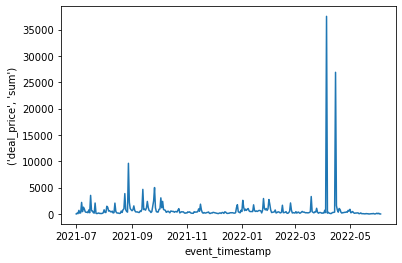

In [64]:
_ = sns.lineplot(data=df, x='event_timestamp', y=('deal_price', 'sum'))

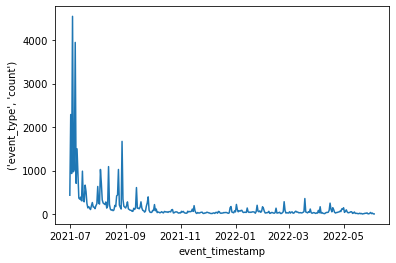

In [65]:
_ = sns.lineplot(data=df, x='event_timestamp', y=('event_type', 'count'))

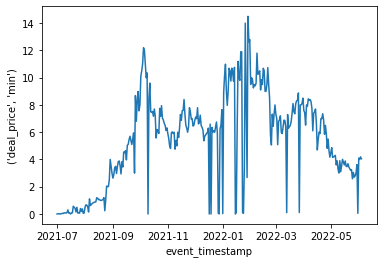

In [66]:
_ = sns.lineplot(data=df, x='event_timestamp', y=('deal_price', 'min'))

Subsetting the event by date

In [67]:
wallets.set_index("event_timestamp").loc['2021-10-10']

,event_type,token_id,num_sales,listing_time,token_owner_address,token_seller_address,from_account_address,deal_price,payment_token_symbol,payment_token_usdprice,...,contract_address,wallet_address_input,dev_fee_payment_event,dev_seller_fee_basis_points,transaction_from_account_address,transaction_to_account_address,winner_account_address,deal_price_usd,cashflow,cashflow_usd
event_timestamp,,,,,,,,,,,,,,,,,,,,,
2021-10-10 22:09:06,buy,6761,1.0,2021-10-10 22:05:06,0x22777214fc28007f3ffa76c1d57e40a06e41ca3f,0xcae9ef9ea4470703bad828cd623a0c5f1da7d0b1,None,2.500000,ETH,2075.53,...,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,0x25aaf13451e66f4f322a6105f7b295d1a7e9da96,None,NaN,None,None,None,5188.825000,-2.500000,-5188.825000
2021-10-10 12:20:45,buy,16407,3.0,2021-10-09 13:14:31,0xf963837cf127d561c8e0c4691ebd5c2e4828c5ee,0x4ce73cc57943602df15fccf1ee291c5d67d38326,None,5.550000,ETH,2086.88,...,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,0x2a1c77a684426fe6ced7a3fca5878fed76fdd1a3,None,NaN,None,None,None,11582.184000,-5.550000,-11582.184000
2021-10-10 20:47:12,sell,1986,4.0,2021-10-09 17:02:20,0xe6f45376f64e1f568bd1404c155e5ffd2f80f7ad,0x122f0465362d9edc8336353f2ad2b61de2b2e413,None,1.900000,ETH,2096.03,...,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,0x122f0465362d9edc8336353f2ad2b61de2b2e413,None,NaN,None,None,None,3982.457000,1.900000,3982.457000
2021-10-10 00:00:39,sell,4658,10.0,NaT,0xc3821ba22772f5576e3af51fdb95cce5c11ec915,0x014f3a8bbcc20c17428a8ee9214f4923e30ba4ee,None,3.993073,WETH,2088.45,...,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,0x014f3a8bbcc20c17428a8ee9214f4923e30ba4ee,None,NaN,None,None,None,8339.332926,3.993073,8339.332926
2021-10-10 17:51:52,sell,2354,2.0,2021-10-10 17:22:52,0xfae4329dcb62fc669f5665201a0b44e5ac8b8357,0x6004df4a6440d89643cc8c37871d5c79745ab711,None,38.600000,ETH,2061.76,...,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,0x6004df4a6440d89643cc8c37871d5c79745ab711,None,NaN,None,None,None,79583.936000,38.600000,79583.936000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-10 23:46:34,sell,8351,3.0,2021-10-10 13:23:44,0xeaa6a5462ef9faf403c7f301fa94523879bdddb6,0xc0df18d3c0dff4580a96c1a2f046c9dcca7aa704,None,55.000000,ETH,2384.59,...,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,0xc0df18d3c0dff4580a96c1a2f046c9dcca7aa704,None,NaN,None,None,None,131152.450000,55.000000,131152.450000
2021-10-10 23:51:19,buy,8106,3.0,2021-10-10 23:49:09,0xabcd84a334cee6b646338871c387bb869b6f09a4,0x1f3aa32266a371d1465c7577b6ed9740dfcdc30a,None,6.499000,ETH,1864.00,...,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,0xe3cfcf65748f88cd77847e5b82cf731d56204c70,"{'asset': None, 'asset_bundle': None, 'event_t...",0.0,0xe3cfcf65748f88cd77847e5b82cf731d56204c70,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,0xe3cfcf65748f88cd77847e5b82cf731d56204c70,12114.136000,-6.499000,-12114.136000
2021-10-10 23:51:19,sell,8106,3.0,2021-10-10 23:49:09,0xabcd84a334cee6b646338871c387bb869b6f09a4,0x1f3aa32266a371d1465c7577b6ed9740dfcdc30a,None,6.499000,ETH,1897.00,...,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,0x1f3aa32266a371d1465c7577b6ed9740dfcdc30a,"{'asset': None, 'asset_bundle': None, 'event_t...",0.0,0xe3cfcf65748f88cd77847e5b82cf731d56204c70,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,0xe3cfcf65748f88cd77847e5b82cf731d56204c70,12328.603000,6.499000,12328.603000


In [68]:
wallets.groupby(["event_timestamp", "event_type"]).sum()

num_sales  deal_price  payment_token_usdprice  \
event_timestamp     event_type                                                  
2021-04-30 12:38:59 buy               2.0        0.16                 1971.49   
                    sell              2.0        0.16                 1862.26   
2021-05-01 00:15:48 buy               5.0        0.10                 1969.56   
                    sell              5.0        0.10                 1902.45   
2021-05-01 00:50:09 buy               6.0        0.08                 1889.29   
...                                   ...         ...                     ...   
2022-06-10 10:25:22 buy               2.0        0.25                 1690.88   
2022-06-10 13:02:49 sell              1.0       87.56                 1577.34   
2022-06-10 13:05:34 buy               2.0        1.57                 1564.51   
2022-06-10 20:08:13 sell              2.0        1.50                 1578.27   
2022-06-11 11:31:00 sell              5.0       21.50                 1562.85   

                                quantity  block_number  is_private  \
event_timestamp     event_type                                       
2021-04-30 12:38:59 buy              1.0    12341856.0         0.0   
                    sell             1.0    12341856.0         0.0   
2021-05-01 00:15:48 buy              1.0    12345019.0         0.0   
                    sell             1.0    12345019.0         0.0   
2021-05-01 00:50:09 buy              1.0    12345174.0         0.0   
...                                  ...           ...         ...   
2022-06-10 10:25:22 buy              1.0    14937924.0         0.0   
2022-06-10 13:02:49 sell             1.0    14938557.0         0.0   
2022-06-10 13:05:34 buy              1.0    14938571.0         0.0   
2022-06-10 20:08:13 sell             1.0    14940306.0         0.0   
2022-06-11 11:31:00 sell             1.0    14944027.0         0.0   

                                dev_seller_fee_basis_points  deal_price_usd  \
event_timestamp     event_type                                                
2021-04-30 12:38:59 buy                                 0.0        315.4384   
                    sell                                0.0        297.9616   
2021-05-01 00:15:48 buy                                 0.0        196.9560   
                    sell                                0.0        190.2450   
2021-05-01 00:50:09 buy                                 0.0        151.1432   
...                                                     ...             ...   
2022-06-10 10:25:22 buy                               250.0        422.7200   
2022-06-10 13:02:49 sell                              250.0     138111.8904   
2022-06-10 13:05:34 buy                               500.0       2456.2807   
2022-06-10 20:08:13 sell                              500.0       2367.4050   
2022-06-11 11:31:00 sell                              250.0      33601.2750   

                                cashflow  cashflow_usd  
event_timestamp     event_type                          
2021-04-30 12:38:59 buy            -0.16     -315.4384  
                    sell            0.16      297.9616  
2021-05-01 00:15:48 buy            -0.10     -196.9560  
                    sell            0.10      190.2450  
2021-05-01 00:50:09 buy            -0.08     -151.1432  
...                                  ...           ...  
2022-06-10 10:25:22 buy            -0.25     -422.7200  
2022-06-10 13:02:49 sell           87.56   138111.8904  
2022-06-10 13:05:34 buy            -1.57    -2456.2807  
2022-06-10 20:08:13 sell            1.50     2367.4050  
2022-06-11 11:31:00 sell           21.50    33601.2750  

[482130 rows x 10 columns]

In [69]:
wallets.groupby(pd.Grouper(key="event_timestamp", freq="1D")).sum()

,num_sales,deal_price,payment_token_usdprice,quantity,block_number,is_private,dev_seller_fee_basis_points,deal_price_usd,cashflow,cashflow_usd
event_timestamp,,,,,,,,,,
2021-04-30,4.0,0.320000,3.833750e+03,2.0,2.468371e+07,0.0,0.0,6.134000e+02,0.000000,-17.476800
2021-05-01,12264.0,5015.825201,6.534186e+06,3425.0,4.224577e+10,4.0,900.0,2.082685e+06,2.223081,41044.123730
2021-05-02,11142.0,2567.318324,6.156135e+06,3303.0,3.974591e+10,10.0,293.0,4.883745e+06,-8.172436,93787.019679
2021-05-03,12050.0,9021.653357,6.550900e+06,3529.0,4.342747e+10,8.0,2550.0,1.605042e+07,-25.430713,-244201.190981
2021-05-04,7548.0,19776.784823,4.459826e+06,2459.0,3.028757e+10,13.0,454.0,2.132939e+07,-45.655041,-760773.817635
...,...,...,...,...,...,...,...,...,...,...
2022-06-07,47.0,181.565890,2.994108e+04,17.0,2.536502e+08,0.0,6750.0,3.127030e+05,144.343890,245964.822212
2022-06-08,112.0,339.135000,4.958452e+04,30.0,4.477895e+08,0.0,10950.0,5.389010e+05,102.627000,159952.045660
2022-06-09,33.0,25.589000,1.697020e+04,10.0,1.493295e+08,0.0,3600.0,4.347787e+04,-4.411000,-8176.112320


## Which user has bought and sold NFT during the specified period?

In [70]:
x = wallets.groupby("wallet_address_input")["event_type"].nunique().reset_index()
x = x[x.event_type > 1]

In [71]:
y = wallets.merge(x, on="wallet_address_input")
y.set_index("event_timestamp", inplace=True)

In [72]:
y.loc["2022-04"]["wallet_address_input"].nunique()
#query('wallet_address_input == "0xfffa6fc6acc3dbe04b175862376f1c5ff88cf9c1"')

10255

In [73]:
hide_columns = ['token_owner_address', 'payment_token_decimals',
                'payment_token_usdprice',
                'transaction_hash', 'block_hash', 'block_number']
wallets.loc[:,~wallets.columns.isin(hide_columns)]

,event_timestamp,event_type,token_id,num_sales,listing_time,token_seller_address,from_account_address,deal_price,payment_token_symbol,quantity,...,contract_address,wallet_address_input,dev_fee_payment_event,dev_seller_fee_basis_points,transaction_from_account_address,transaction_to_account_address,winner_account_address,deal_price_usd,cashflow,cashflow_usd
4436,2022-05-01 14:44:35,buy,4052,5.0,2022-05-01 14:29:35.000000,0xc36f91dbdbb526cda9ffd9c62589b749b69107ba,None,1.1500,ETH,1.0,...,0x7f268357a8c2552623316e2562d90e642bb538e5,0xc95555d043fc4e92424de99620e06aa791bd282e,None,NaN,None,None,None,2220.960500,-1.1500,-2220.960500
5496,2021-07-28 14:01:17,buy,6452,1.0,2021-07-28 13:57:33.000000,0xa621164c4fcfe74e86093cbfa5fc84ae4991fd13,None,0.0790,ETH,1.0,...,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,0x18c43569593a10c124fb738c00c33b75748b971e,None,NaN,None,None,None,152.570330,-0.0790,-152.570330
5951,2022-05-17 17:10:04,buy,8818,3.0,2022-05-17 16:52:15.000000,0x809ca3f5ffb4b371733064b9c9f32f44bb969583,None,0.8955,ETH,1.0,...,0x7f268357a8c2552623316e2562d90e642bb538e5,0x03656157c5aa0f676af5d3046806fca21bd232d0,None,NaN,None,None,None,1729.452285,-0.8955,-1729.452285
7590,2022-04-23 04:20:07,buy,4010,4.0,2022-04-23 04:09:10.000000,0x03009898ffd3361bb6b02b77d655f196ec82865e,None,1.1700,ETH,1.0,...,0x7f268357a8c2552623316e2562d90e642bb538e5,0xe48fb5faefa99a05cbbd3682a69abd8e18d9a841,None,NaN,None,None,None,2259.585900,-1.1700,-2259.585900
9873,2022-05-27 00:53:28,buy,9243,3.0,2022-05-26 20:55:08.147521,0x998d5a6944b192e247010945e2a10768b910385c,None,0.6000,ETH,1.0,...,0x7f268357a8c2552623316e2562d90e642bb538e5,0xcc92f5da26f156681fa6eee8e63bfeec605d228f,None,NaN,None,None,None,1157.286000,-0.6000,-1157.286000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271625,2022-05-31 16:32:44,buy,6619,2.0,2022-05-22 14:10:48.807905,0xfb78744f74cfbdded825e72888ac58b939c02a9f,None,4.5000,ETH,1.0,...,0x7f268357a8c2552623316e2562d90e642bb538e5,0xc9c8b4eac943589e4a9a6b26a6ce984fe9205a4e,"{'asset': None, 'asset_bundle': None, 'event_t...",500.0,0xc9c8b4eac943589e4a9a6b26a6ce984fe9205a4e,0x7f268357a8c2552623316e2562d90e642bb538e5,0xc9c8b4eac943589e4a9a6b26a6ce984fe9205a4e,8364.510000,-4.5000,-8364.510000
138264,2022-06-01 08:22:25,buy,4676,6.0,2022-06-01 08:17:55.687051,0xe8b22a88deb45c7848d394fd039b8d811511a9f3,None,12.0000,ETH,1.0,...,0x7f268357a8c2552623316e2562d90e642bb538e5,0x7b166c7d23bae9896e1d42adecdbabea1ced3f0d,"{'asset': None, 'asset_bundle': None, 'event_t...",500.0,0x7b166c7d23bae9896e1d42adecdbabea1ced3f0d,0x7f268357a8c2552623316e2562d90e642bb538e5,0x7b166c7d23bae9896e1d42adecdbabea1ced3f0d,21238.440000,-12.0000,-21238.440000
26678,2022-06-02 01:34:58,buy,9443,2.0,2022-06-01 22:31:32.794843,0xe3f663418251186888935dc1c4979fa3a3da1bac,None,21.6000,ETH,1.0,...,0x7f268357a8c2552623316e2562d90e642bb538e5,0x8f46d017455920ecbf72d04d95505208aaf03581,"{'asset': None, 'asset_bundle': None, 'event_t...",500.0,0x8f46d017455920ecbf72d04d95505208aaf03581,0x7f268357a8c2552623316e2562d90e642bb538e5,0x8f46d017455920ecbf72d04d95505208aaf03581,40187.880000,-21.6000,-40187.880000
179059,2022-06-05 15:37:39,sell,7167,5.0,2022-06-05 07:16:44.000000,0x4fa94ca44d1c403c7a864a4e6fb885cc3f6e92bb,None,4.1900,ETH,1.0,...,0x7f268357a8c2552623316e2562d90e642bb538e5,0x4fa94ca44d1c403c7a864a4e6fb885cc3f6e92bb,None,400.0,0x0cc901998f14e88b7669e7a01863acc8f64905f7,0x7f268357a8c2552623316e2562d90e642bb538e5,0x0cc901998f14e88b7669e7a01863acc8f64905f7,7810.160000,4.1900,7810.160000


## Collections

Checking out the size  aka the number of sales by collection

In [74]:
df=wallets.groupby("collection_slug", as_index=False).size() \
    .sort_values("size", ascending=False).reset_index(drop=True)
df.head(20)

,collection_slug,size
0,cool-cats-nft,51356
1,lazy-lions,48777
2,mutant-ape-yacht-club,48611
3,boredapeyachtclub,46991
4,world-of-women-nft,41479
5,bored-ape-kennel-club,34723
6,cryptoadz-by-gremplin,34225
7,meebits,32332
8,phantabear,31019
9,azuki,30223


_Are these popular collections on OpenSea or is it bias from data collection process?_

In [75]:
df.query('size < 100')

,collection_slug,size


_Private / personal collections?_

In [76]:
wallets.groupby(["collection_slug", "event_type"], as_index=False).size() \
    .pivot(index="collection_slug", columns="event_type", values="size") \
    .assign(diff=lambda x: x.buy - x.sell) \
    .sort_values(by=["buy", "sell"], ascending=False).head(20)

event_type,buy,sell,diff
collection_slug,,,
cool-cats-nft,25806,25550,256
lazy-lions,24873,23904,969
mutant-ape-yacht-club,23927,24684,-757
boredapeyachtclub,23358,23633,-275
world-of-women-nft,21182,20297,885
bored-ape-kennel-club,17540,17183,357
cryptoadz-by-gremplin,17359,16866,493
meebits,16410,15922,488
azuki,15898,14325,1573


It is reasonable to expect there are more buy events for a given collection,
but how do we explain more selling events? Could it be mint > transfer > sell>

## NFT_ID

a complex key created from `collection_slug` and `token_id` equals NFT unique ID

In [77]:
wallets["nft_id"] = wallets.collection_slug + '-' + wallets.token_id

In [78]:
wallets.groupby(["collection_slug", "nft_id", "event_type"], as_index=False).size() \
    .pivot(index=["collection_slug", "nft_id"], columns="event_type", values="size") \
    .sort_values(by=["buy", "sell"], ascending=False).head(20)

event_type                                         buy  sell
collection_slug       nft_id                                
cool-cats-nft         cool-cats-nft-9561          17.0  17.0
bored-ape-kennel-club bored-ape-kennel-club-1306  16.0  15.0
                      bored-ape-kennel-club-2937  15.0  16.0
                      bored-ape-kennel-club-2829  15.0  15.0
kaiju-kingz           kaiju-kingz-3335            15.0  15.0
bored-ape-kennel-club bored-ape-kennel-club-9220  14.0  14.0
cool-cats-nft         cool-cats-nft-3893          14.0  14.0
                      cool-cats-nft-7240          14.0  13.0
bored-ape-kennel-club bored-ape-kennel-club-7913  14.0  11.0
cool-cats-nft         cool-cats-nft-426           13.0  14.0
bored-ape-kennel-club bored-ape-kennel-club-5858  13.0  13.0
boredapeyachtclub     boredapeyachtclub-6843      13.0  13.0
                      boredapeyachtclub-9627      13.0  13.0
cool-cats-nft         cool-cats-nft-6225          13.0  13.0
                      cool-cats-nft-6961          13.0  13.0
                      cool-cats-nft-7156          13.0  13.0
cryptoadz-by-gremplin cryptoadz-by-gremplin-6481  13.0  13.0
lazy-lions            lazy-lions-1163             13.0  13.0
boredapeyachtclub     boredapeyachtclub-4962      13.0  12.0
                      boredapeyachtclub-9109      13.0  12.0

_*Tokens that have been exchanged mulitple times._

# Exporting Data for Other Experiments

# Note
Feature engineering in ML
1. Feature Creation
1. Transformations
1. Feature Extraction
1. and Feature Selection.